## COVID-19 PAKISTAN ANALYSIS & PROJECTIONS

### Packages

In [1]:
import numpy as np
import pandas as pd
import datetime
import math
from pandas import read_excel
from scipy.optimize import minimize
#Import matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#plt.style.use('fivethirtyeight')
%matplotlib inline

# Import Prophet
import plotly.offline as py
#import plotly.express as px
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from datetime import datetime, timedelta

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
# hide warnings
import warnings
warnings.filterwarnings('ignore')


#### Province wise Data Model: 

In [2]:
import requests
import io

# Username of GitHub account

username = 'abdulbarimalik'

# Personal Access Token (PAO) from GitHub account

token = 'a5389dd2ed961708e248000815bfb4a638f2b6e8'

# Creates a re-usable session object with creds in-built

github_session = requests.Session()
github_session.auth = (username, token)
    
# Downloading the csv file from GitHub

url = "https://raw.githubusercontent.com/abdulbarimalik/COVID19/master/Covid-19-PAK.csv?token=AB6MNPZN2XR4SASSW4JSSO26YS46Q" # Make sure the url is the raw version of the file on GitHub
download = github_session.get(url).content

# Reading the downloaded content and making it a pandas dataframe

full_table = pd.read_csv(io.StringIO(download.decode('utf-8')))

In [3]:
# Read  data file
#full_table = pd.read_csv("https://raw.githubusercontent.com/abdulbarimalik/COVID19PAK/master/Covid-19-PAK.csv")
#full_table = pd.read_excel('F:/Data Sets/COVID-19/Pakistan/time series/COVID-19_DATA.xlsx',sheet_name='TimeSeries_KeyIndicators')
# Add Active Cases count
full_table['Active'] = full_table['Cumulative  Test positive'] - full_table['Expired'] - full_table['Discharged']
# Set Date into Pandas date format
full_table['Date'] = pd.to_datetime(full_table['Date'])
# Rename data frame columns
fulltable = full_table.rename(columns={"Cumulative  Test positive": "Confirmed", 
                                       "Expired": "Deaths","Discharged": "Recovered"})


In [4]:
fulltable['Date'] = pd.to_datetime(fulltable['Date'])

In [5]:
# latest condensed
full_latest = fulltable[fulltable['Date'] == max(fulltable['Date'])].reset_index()
full_table_grouped = full_latest.groupby('Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

In [6]:
temp_f = full_table_grouped.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f[['Region', 'Confirmed', 'Active', 'Deaths', 'Recovered']]
temp_f = temp_f.reset_index(drop=True)
temp_f["Mortality Rate (per 100)"] = np.round(100*temp_f["Deaths"]/temp_f["Confirmed"],2)
temp_f.style.background_gradient(cmap="Reds", subset=['Confirmed'])\
            .background_gradient(cmap="Greens", subset=['Recovered'])\
            .background_gradient(cmap="Greys", subset=['Deaths'])\
            .background_gradient(cmap="Blues", subset=['Active'])\
            .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])


## COVID-19 Analysis

In [7]:
def daily_increase(data):
    d = []
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

In [50]:
def autolabel(rects):
    """Attach a text label above each bar , displaying its height."""
    for rect in rects:
        height = rect.get_height()
        #plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom') 
        plt.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 7),  # 4 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', size = 12)

<Figure size 864x576 with 0 Axes>

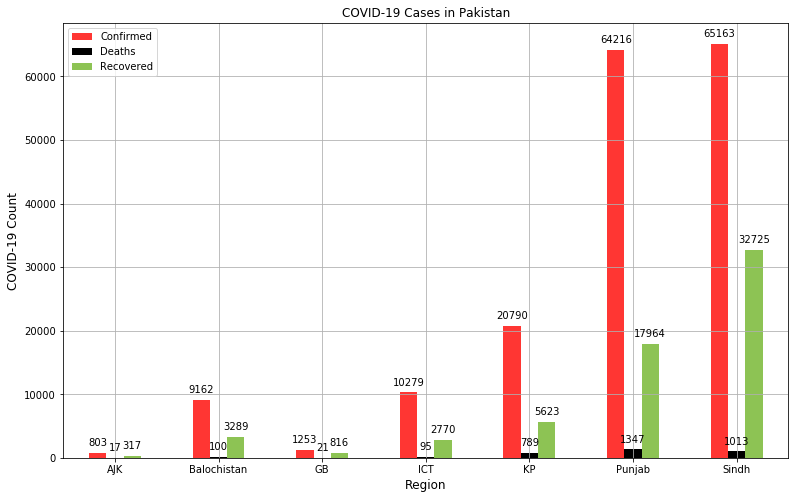

In [51]:
plt.figure(figsize=(12, 8))
pr_plot = full_table_grouped.plot('Region',['Confirmed','Deaths','Recovered'],kind = 'bar', color = ['#FF3633','#000000','#8dc354'], figsize=(13,8),title='COVID-19 Cases in Pakistan')
for p in pr_plot.patches:
    pr_plot.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylabel('COVID-19 Count', size=12)
plt.xlabel('Region', size=12)
pr_plot.set_xticklabels(full_table_grouped['Region'],rotation=360)
plt.grid() 
plt.show()

__COVID-19 Count in Pakistan__

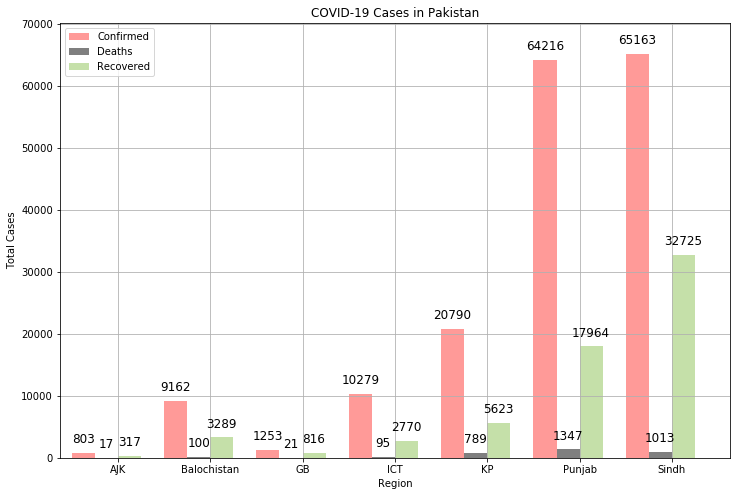

In [52]:
global full_table_grouped
# Setting the positions and width for the bars
pos = list(range(len(full_table_grouped['Confirmed']))) 
width = 0.25 
   
# Plotting the bars
fig, ax = plt.subplots(figsize=(12,8))

# Create a bar with pre_score data,
# in position pos,
barplot1 = plt.bar(pos, 
        #using df['pre_score'] data,
        full_table_grouped['Confirmed'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#FF3633', #'#EE3224' 
        # with label the first value in first_name
        label= full_table_grouped['Region'][0]) 
autolabel(barplot1)
# Create a bar with mid_score data,
# in position pos + some width buffer,
barplot2=plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        full_table_grouped['Deaths'],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#000000' , #'#F78F1E' 
        # with label the second value in first_name
        label=full_table_grouped['Region'][1]) 
autolabel(barplot2)
# Create a bar with post_score data,
# in position pos + some width buffer,
barplot3=plt.bar([p + width*2 for p in pos], 
        #using df['post_score'] data,
        full_table_grouped['Recovered'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#8dc354', #'#FFC222'
        # with label the third value in first_name
        label=full_table_grouped['Region'][2]) 
autolabel(barplot3)
# Set the y axis label
ax.set_ylabel('Total Cases')
ax.set_xlabel('Region')
# Set the chart's title
ax.set_title('COVID-19 Cases in Pakistan')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(full_table_grouped['Region'])

# # Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(full_table_grouped['Confirmed'] + 5000)] )

# Adding the legend and showing the plot
plt.legend(['Confirmed', 'Deaths', 'Recovered'], loc='upper left')
plt.grid()
plt.show()

__COVID-19 Daily Cases in Pakistan__

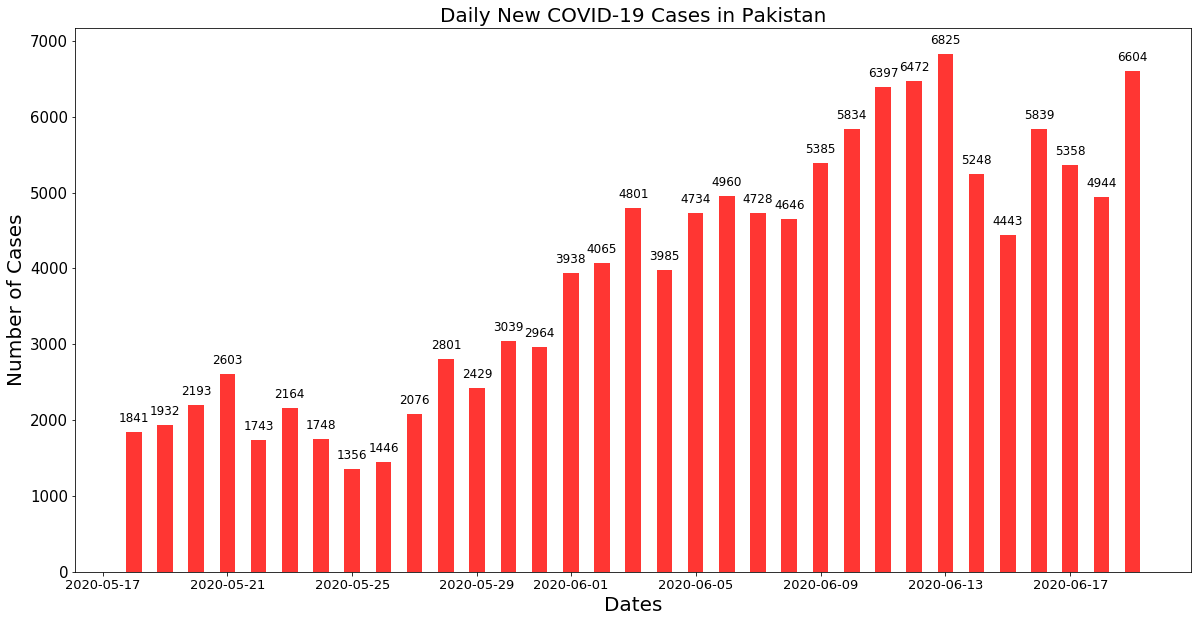

In [53]:
import matplotlib.dates as mdates
predgrp = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
df_t = predgrp.tail(34)
df_cnfrm = df_t.reset_index().drop('index',axis=1)
df_cnfrm
pk_cnfrm_increase = daily_increase(df_cnfrm['Confirmed'])

pk_cnfrm_increase = pk_cnfrm_increase[1:]
pk_cnfrm_increase
plt.figure(figsize=(20, 10))
bar_plot = plt.bar(predgrp['Date'].tail(33), pk_cnfrm_increase, width = 0.5, align = 'center', color = '#FF3633')
autolabel(bar_plot)   
plt.title('Daily New COVID-19 Cases in {}'.format('Pakistan'), size=20)
plt.xlabel('Dates', size=20)
plt.ylabel('Number of Cases', size=20)
plt.xticks(size=13)
plt.yticks(size=15)
plt.show()


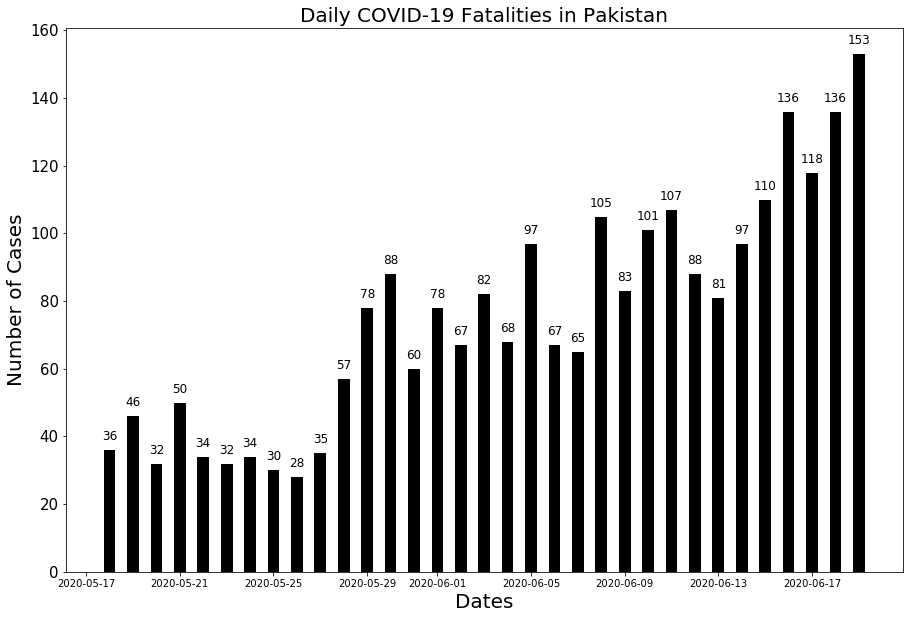

In [54]:
import matplotlib.dates as mdates
predgrp = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
df_t = predgrp.tail(34)
df_fat = df_t.reset_index().drop('index',axis=1)

pk_fat_increase = daily_increase(df_fat['Deaths'])

pk_fat_increase = pk_fat_increase[1:]
pk_fat_increase

plt.figure(figsize=(15, 10))
bar_plot = plt.bar(predgrp['Date'].tail(33), pk_fat_increase, color='#000000', width = 0.5, align = 'center')
autolabel(bar_plot)
plt.title('Daily COVID-19 Fatalities in {}'.format('Pakistan'), size=20)
plt.xlabel('Dates', size=20)
plt.ylabel('Number of Cases', size=20)
plt.xticks(size=10)
plt.yticks(size=15)
plt.show()

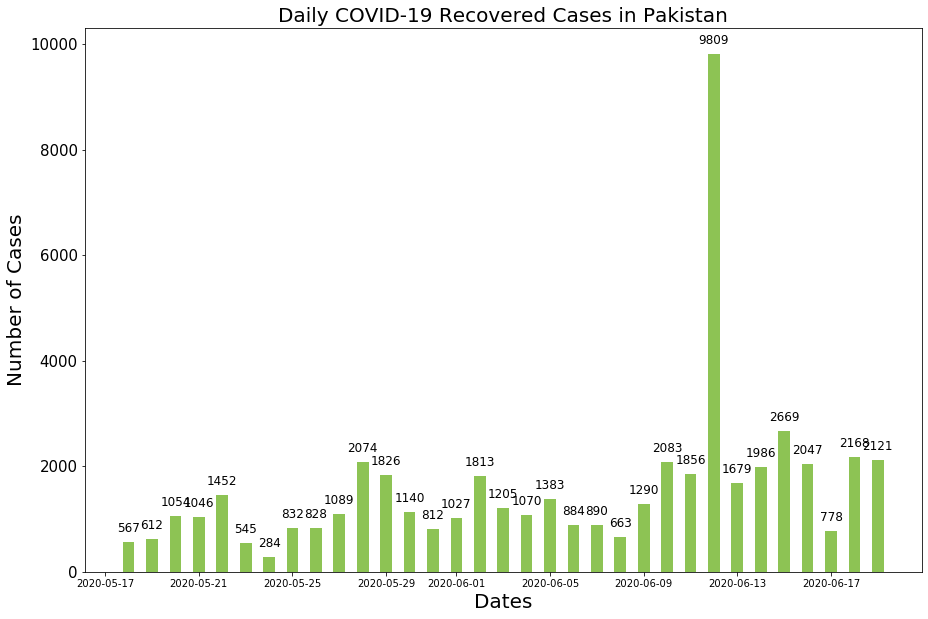

In [55]:
import matplotlib.dates as mdates
predgrp = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()

df_t = predgrp.tail(34)
df_recov = df_t.reset_index().drop('index',axis=1)

pk_recov_increase = daily_increase(df_recov['Recovered'])

pk_recov_increase = pk_recov_increase[1:]

plt.figure(figsize=(15, 10))
bar_plot = plt.bar(predgrp['Date'].tail(33), pk_recov_increase, color = '#8dc354', width = 0.5, align = 'center')
autolabel(bar_plot)
plt.title('Daily COVID-19 Recovered Cases in {}'.format('Pakistan'), size=20)
plt.xlabel('Dates', size=20)
plt.ylabel('Number of Cases', size=20)
plt.xticks(size=10)
plt.yticks(size=15)
plt.show()

In [56]:
import plotly.express as px
import plotly.graph_objs as go

import plotly as py
from plotly import tools
from plotly.offline import iplot
#-------------------------#
fig = go.Figure()
pk_cnfrm_inc = daily_increase(predgrp['Confirmed'])
pk_fat_inc = daily_increase(predgrp['Deaths'])
pk_recov_inc = daily_increase(predgrp['Recovered'])
# Add traces
fig.add_trace(go.Scatter(x=predgrp['Date'], y=pk_cnfrm_inc,
                    mode='lines+markers',
                    name='Cases'))
fig.add_trace(go.Scatter(x=predgrp['Date'], y=pk_fat_inc,
                    mode='lines+markers',
                    name='Deaths'))
fig.add_trace(go.Scatter(x=predgrp['Date'], y=pk_recov_inc,
                    mode='lines+markers',
                    name='Recoveries'))             

fig.show()

__COVID-19 Daily Spread in Provinces (Last 30 Days)__ 

In [57]:
def get_time_series_province(province):
    global fulltable
    df = fulltable[(fulltable['Region'] == province)]
    return df
   

In [58]:
def daily_Cnfrm_Province(df, province):
#    df_t = df[df['Date'] > '2020-04-01']
    df_t = df.tail(31)
    df_cnfrm = df_t.reset_index().drop('index',axis=1)
    pr_cnfrm_inc = daily_increase(df_cnfrm['Confirmed'])
    pr_cnfrm_inc = pr_cnfrm_inc[1:]
    plt.figure(figsize=(15, 10))
    df_cnfrm = df_cnfrm[1:]
    bar_plot = plt.bar(df_cnfrm['Date'], pr_cnfrm_inc, color = '#FF3633', width = 0.5, align = 'center')
    autolabel(bar_plot)
    plt.title('Daily COVID-19 Confirmed Cases in {}'.format(province), size=20)
    plt.xlabel('Dates', size=15)
    plt.ylabel('Number of Cases', size=15)
    plt.xticks(size=10)
    plt.yticks(size=10)
    plt.show() 
#--------------------------#
def daily_Recov_Province(df, province):
    #df_t = df[df['Date'] > '2020-04-01']
    df_t = df.tail(31)
    df_recov = df_t.reset_index().drop('index',axis=1)
    pr_recov_inc = daily_increase(df_recov['Recovered'])
    pr_recov_inc = pr_recov_inc[1:]
    plt.figure(figsize=(15, 10))
    df_recov  = df_recov[1:]
    bar_plot = plt.bar(df_recov['Date'], pr_recov_inc, color = '#8dc354', width = 0.5, align = 'center')
    autolabel(bar_plot)
    plt.title('Daily COVID-19 Recovered Cases in {}'.format(province), size=20)
    plt.xlabel('Dates', size=15)
    plt.ylabel('Number of Cases', size=15)
    plt.xticks(size=10)
    plt.yticks(size=10)
    plt.show() 
#-------------------------#
def daily_Fat_Province(df, province):
    #df_t = df[df['Date'] > '2020-04-01']
    df_t = df.tail(31)
    df_fat = df_t.reset_index().drop('index',axis=1)
    pr_fat_inc = daily_increase(df_fat['Deaths'])
    pr_fat_inc = pr_fat_inc[1:]
    plt.figure(figsize=(15, 10))
    df_fat = df_fat[1:]
    bar_plot = plt.bar(df_fat['Date'], pr_fat_inc, color = '#000000', width = 0.5, align = 'center')
    autolabel(bar_plot)
    plt.title('Daily COVID-19 Fatalities in {}'.format(province), size=20)
    plt.xlabel('Dates', size=15)
    plt.ylabel('Number of Cases', size=15)
    plt.xticks(size=10)
    plt.yticks(size=10)
    plt.show()     

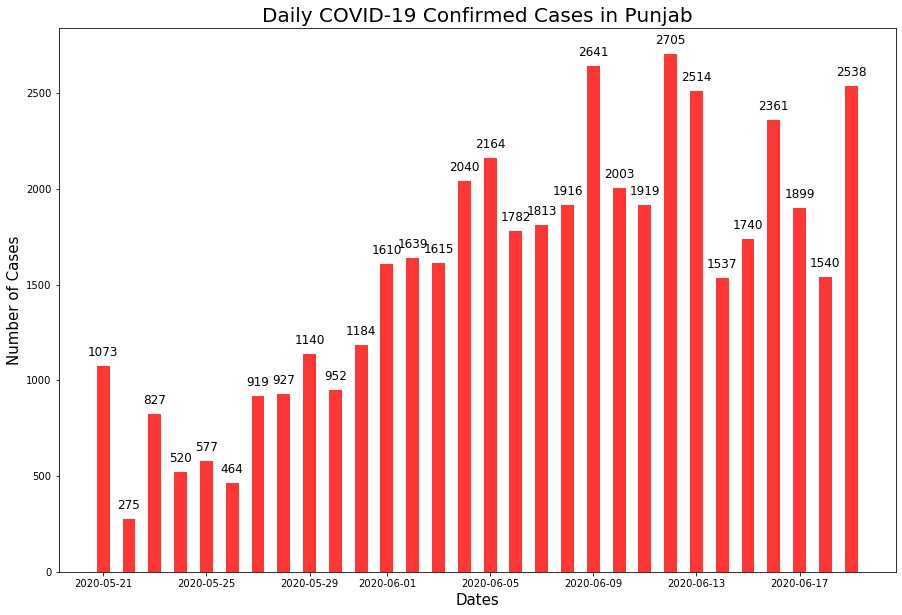

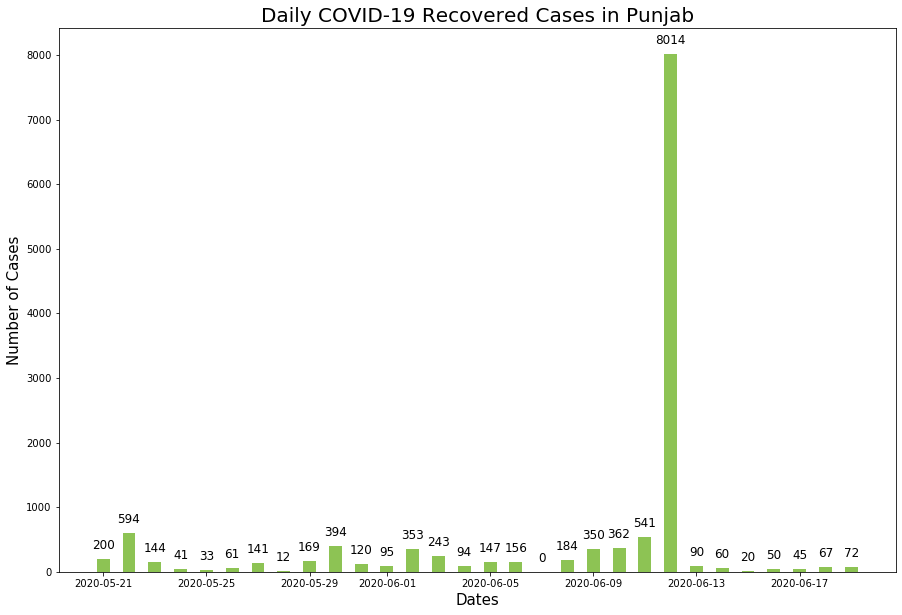

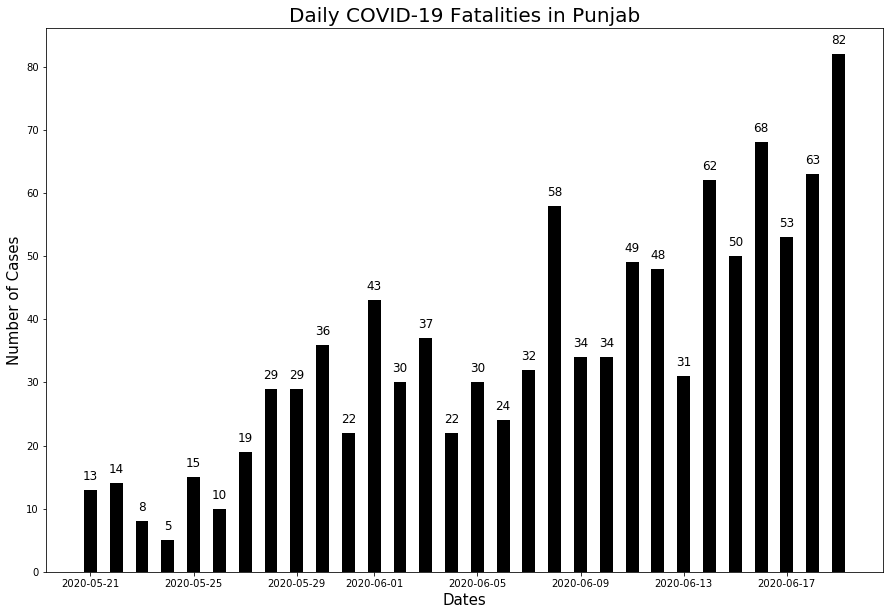

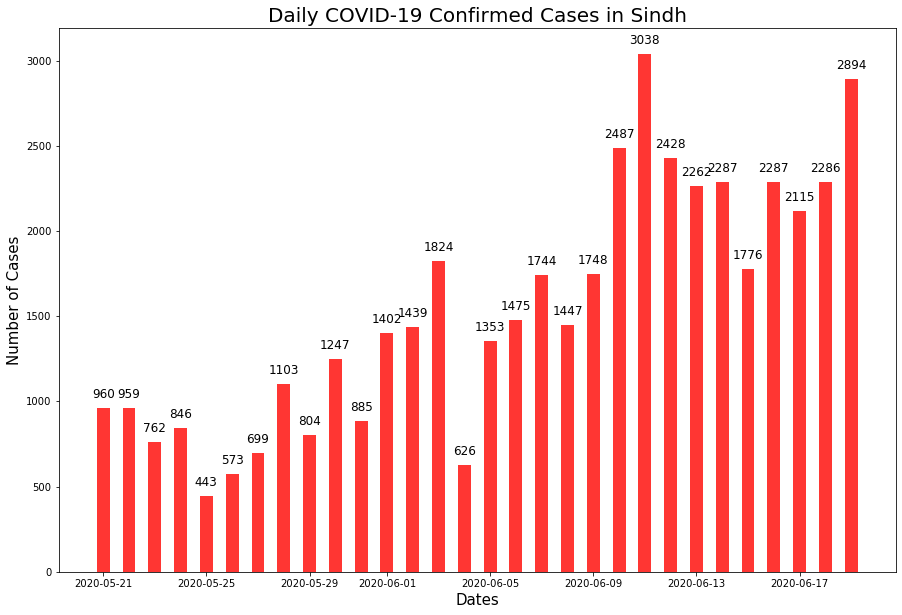

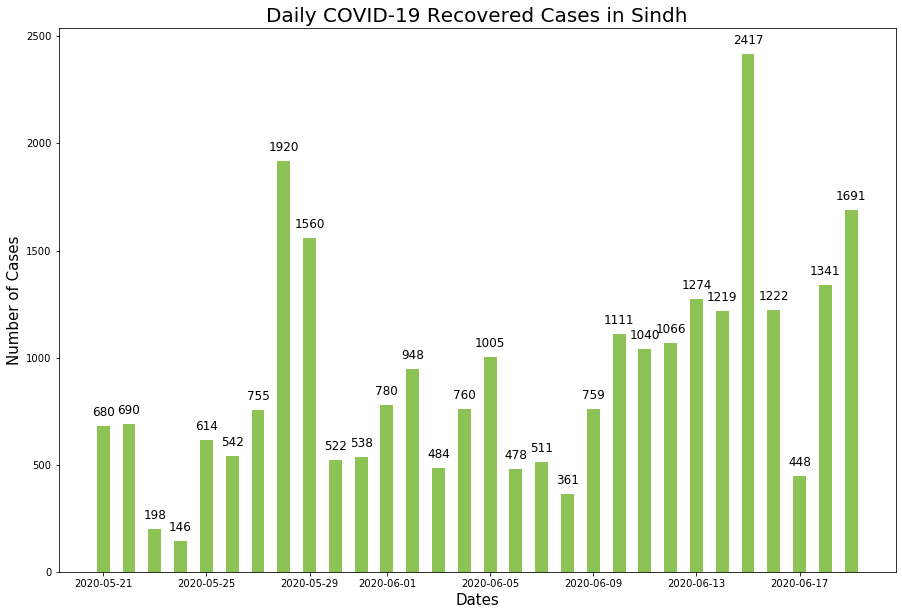

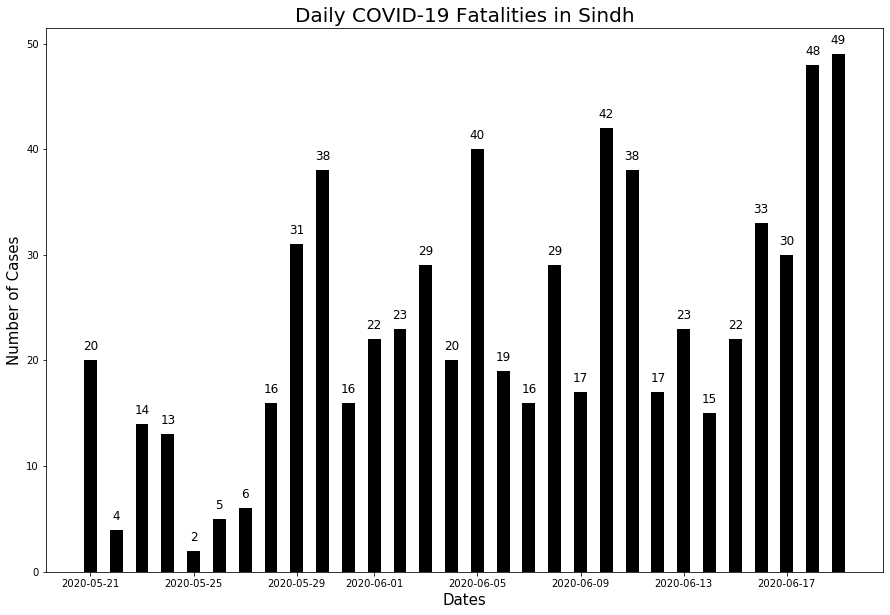

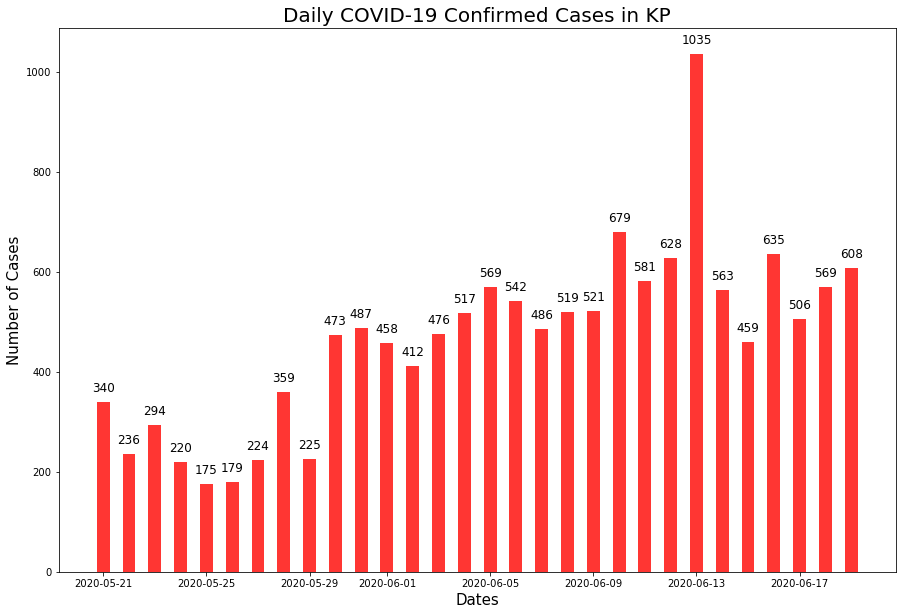

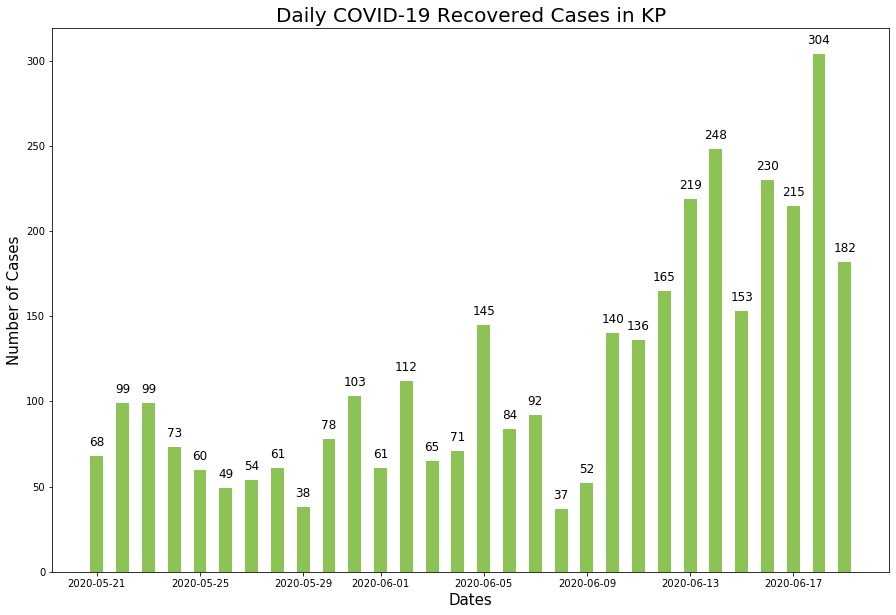

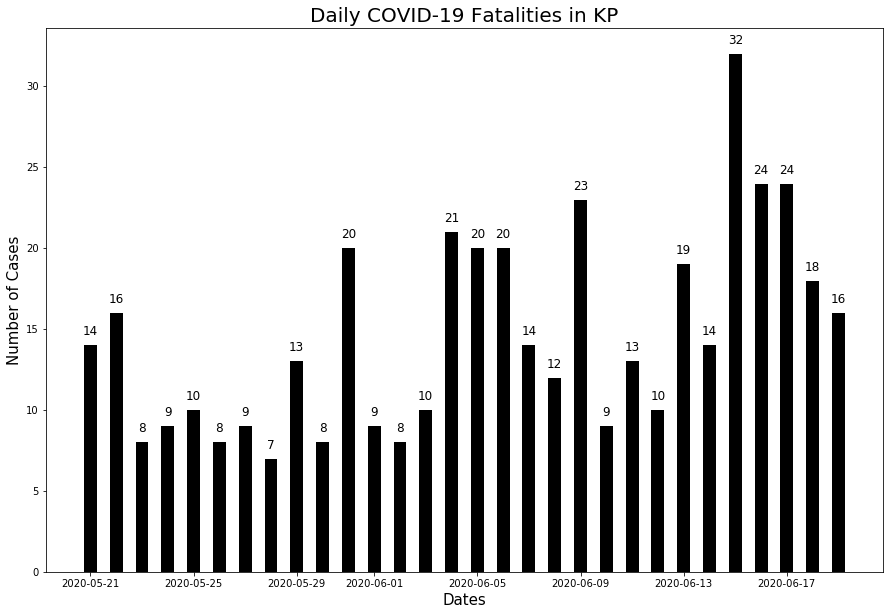

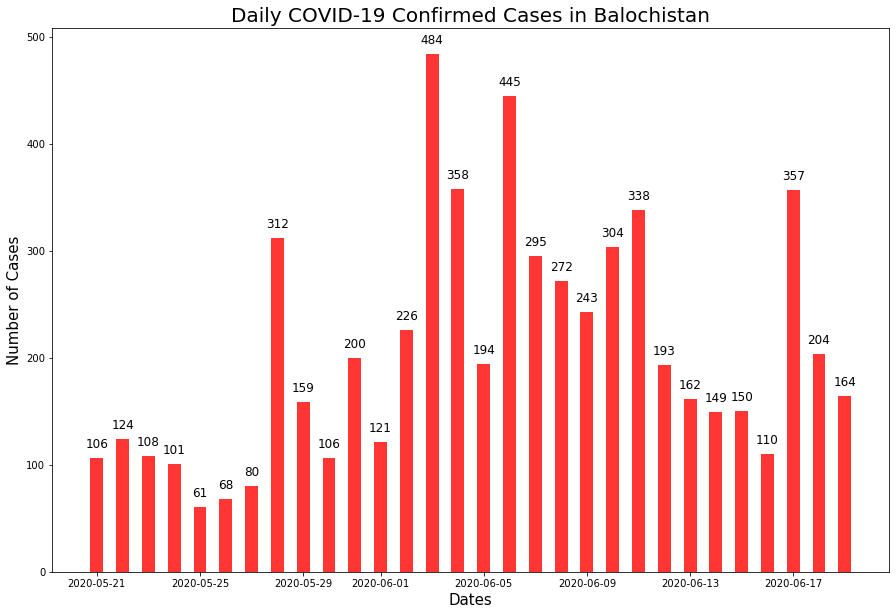

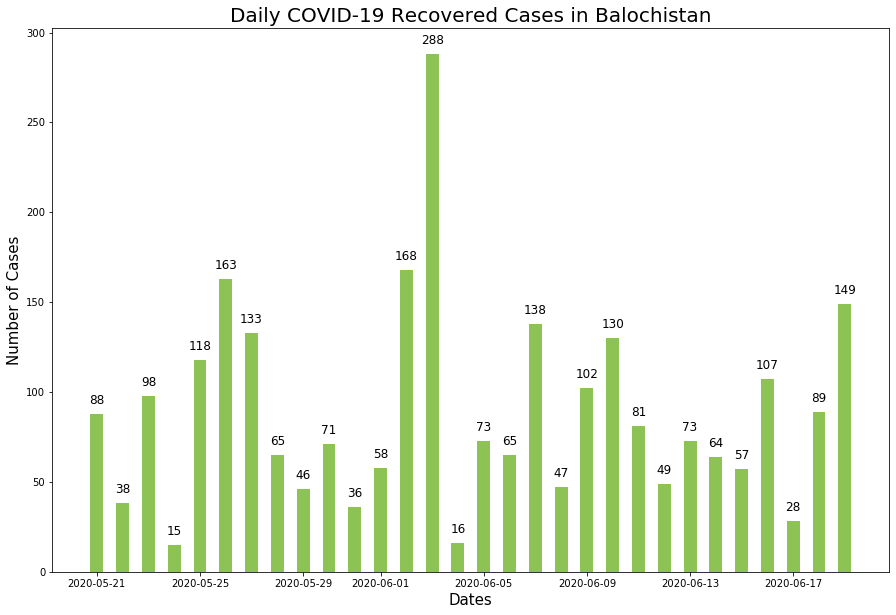

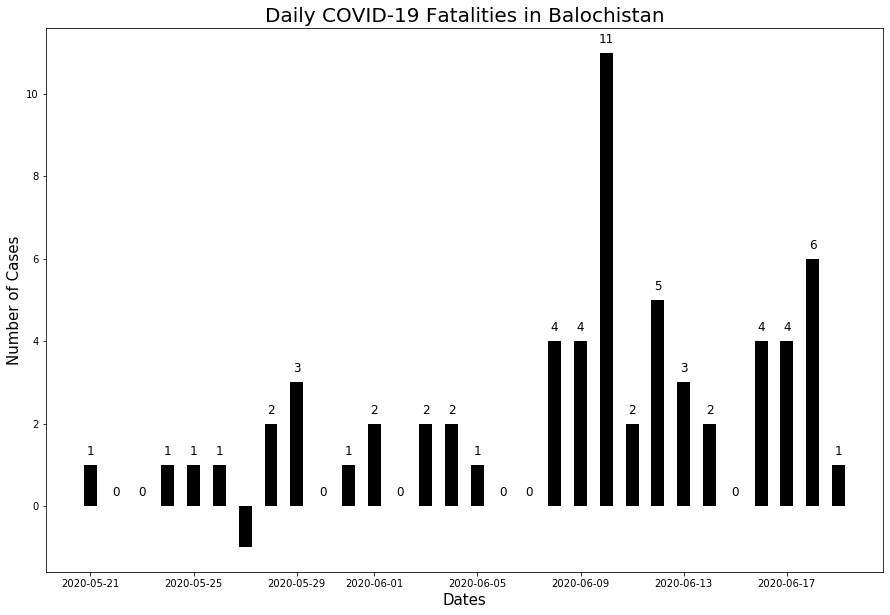

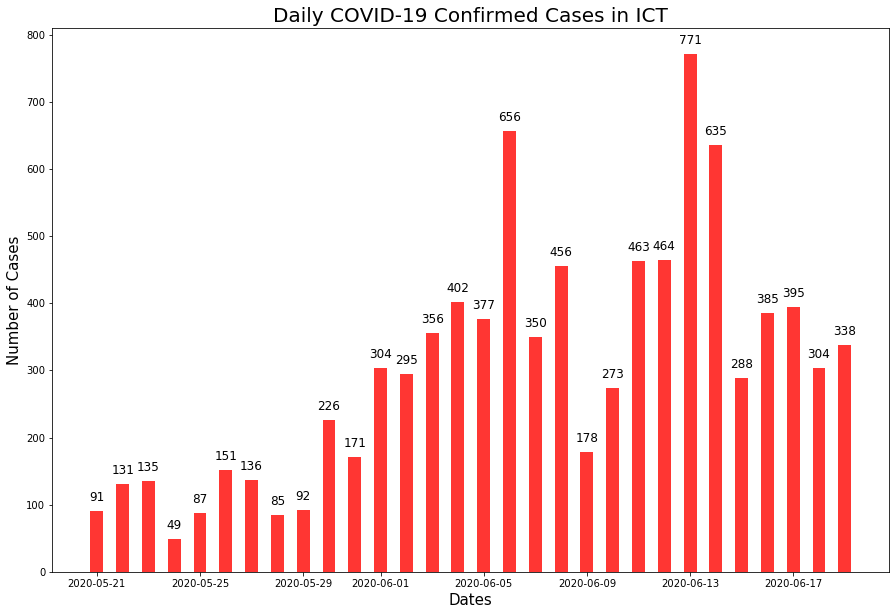

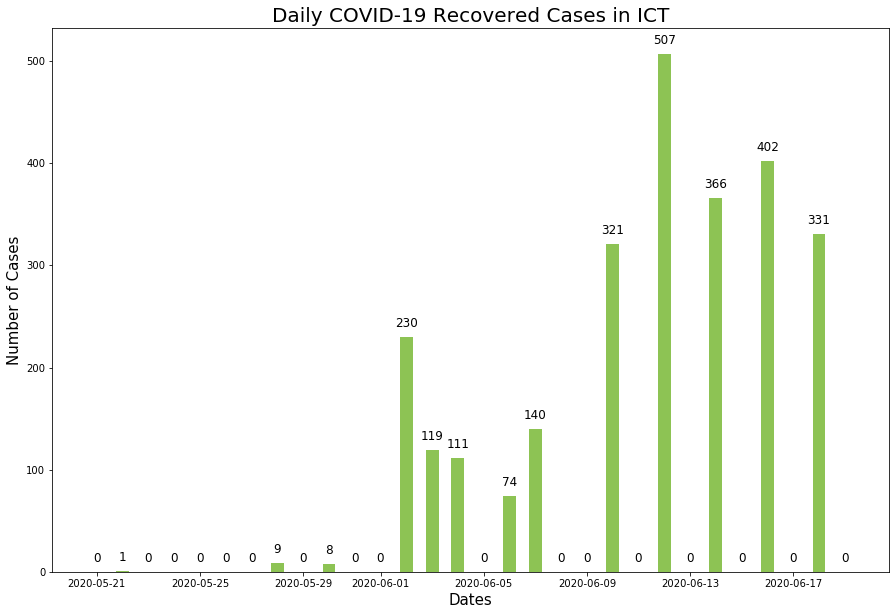

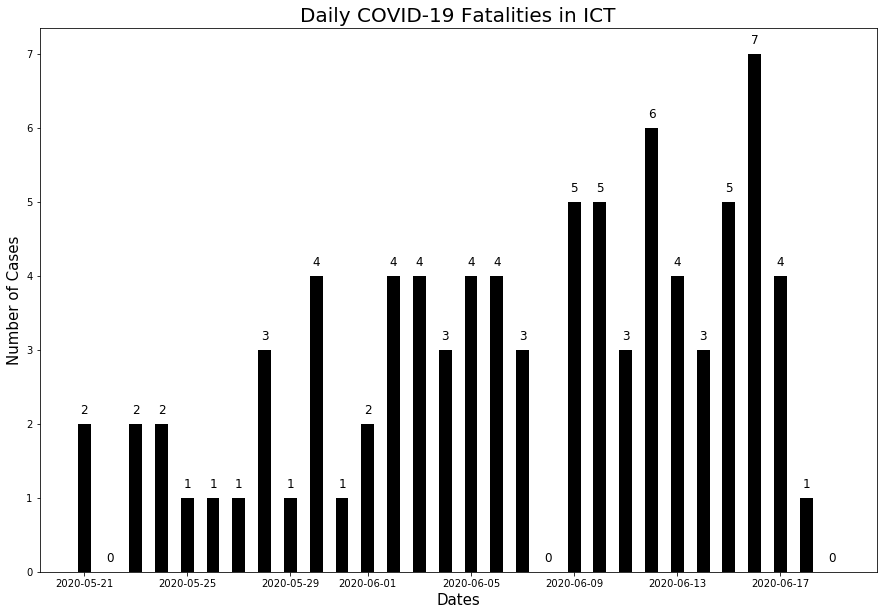

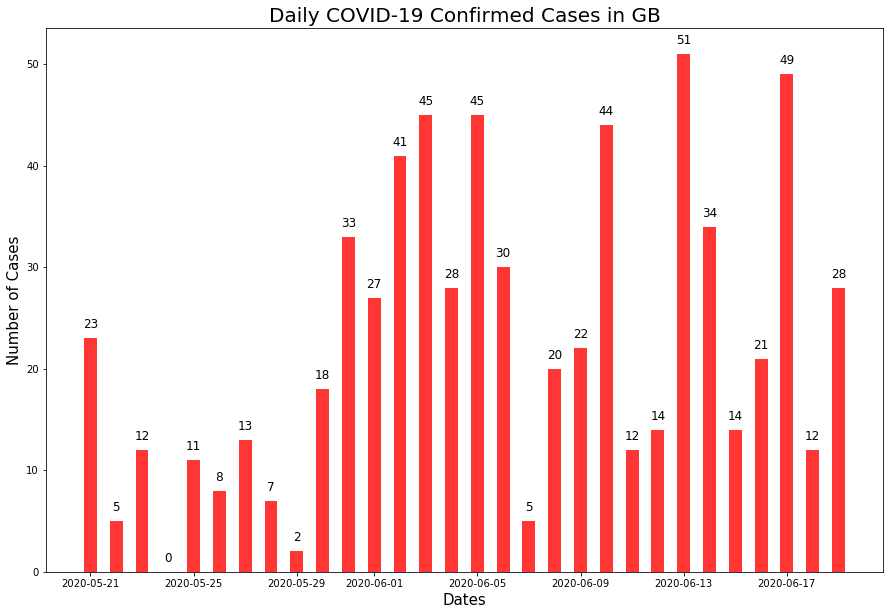

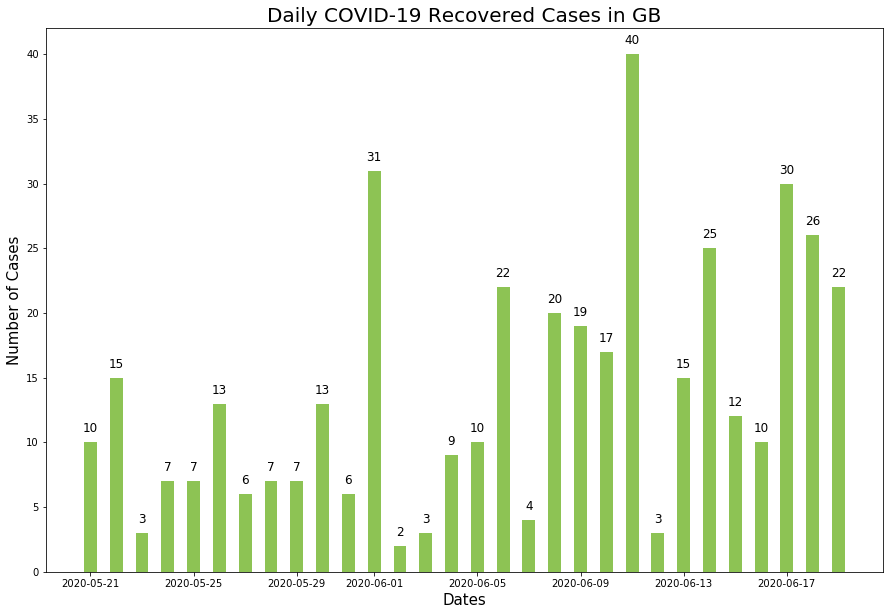

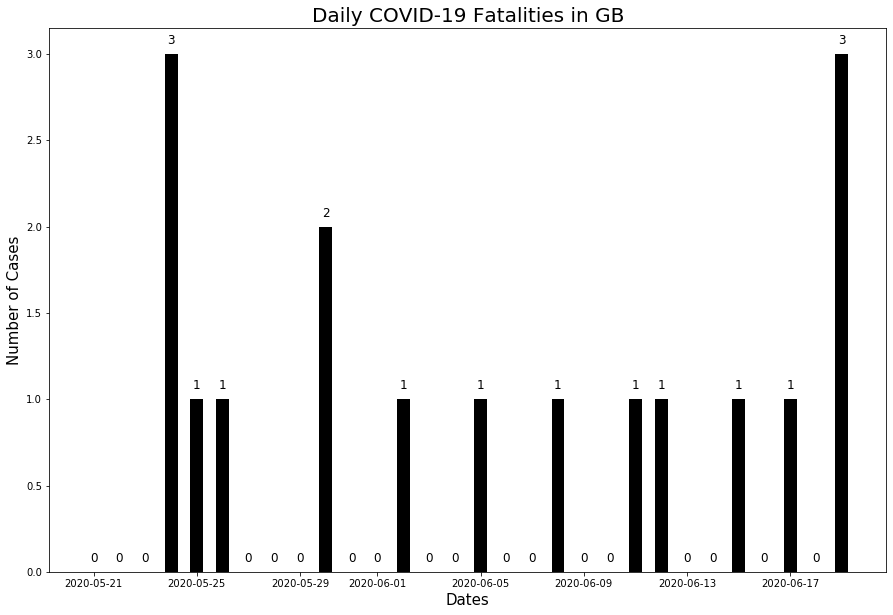

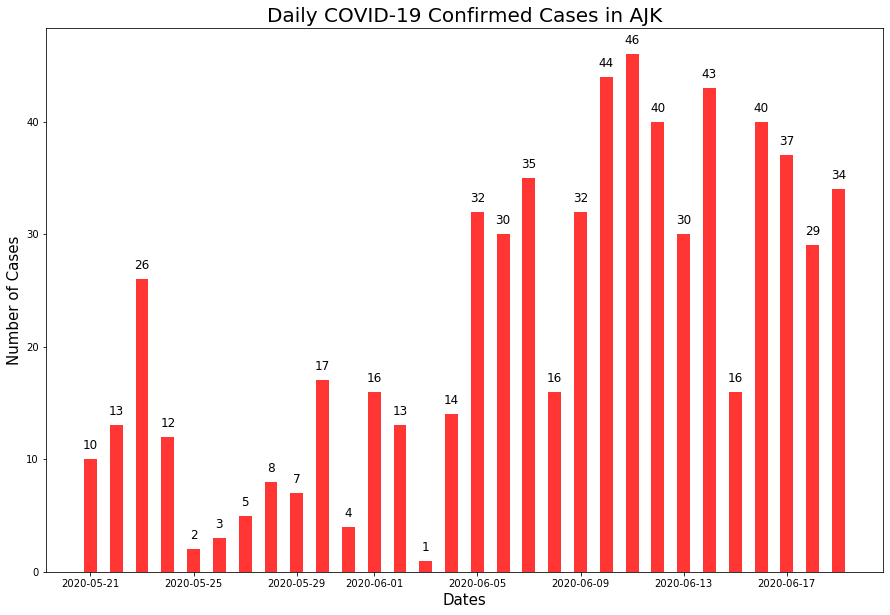

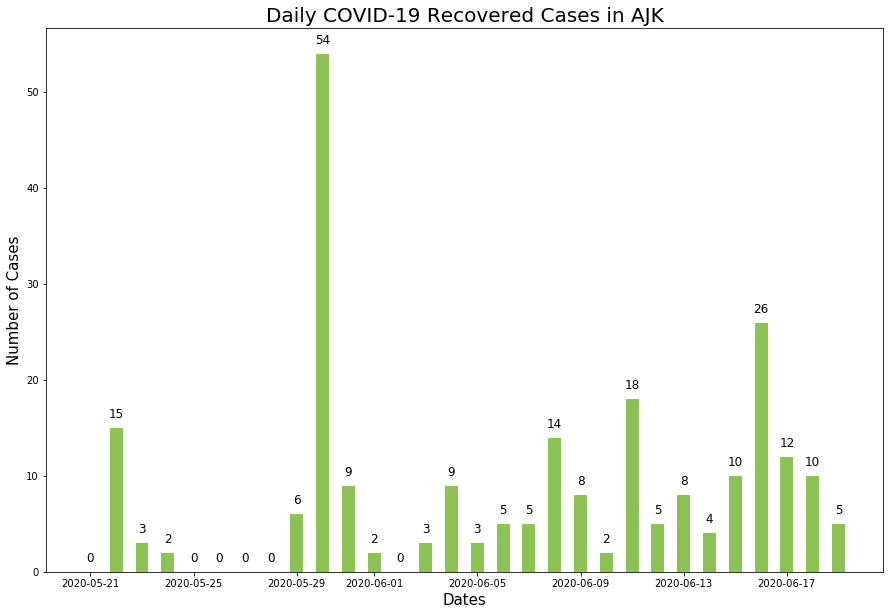

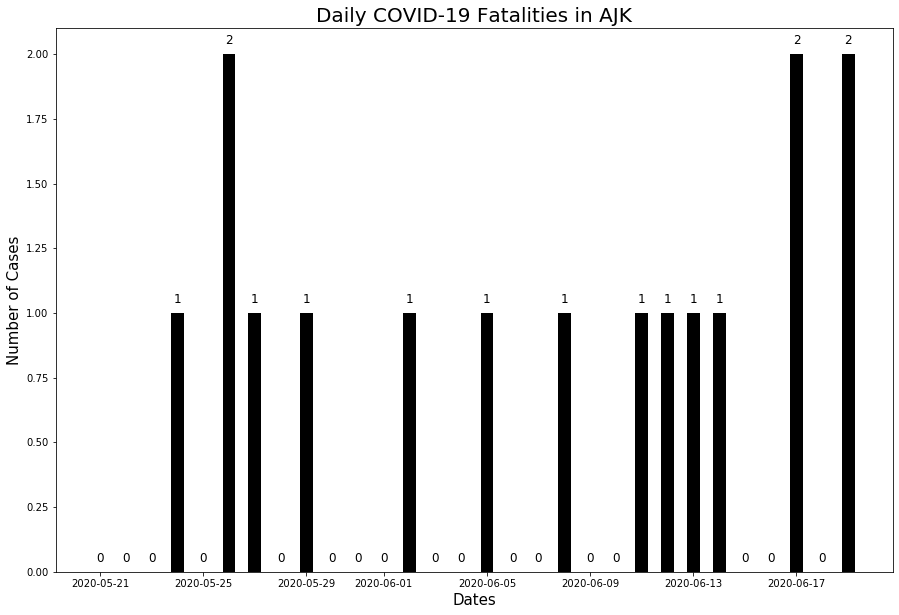

In [59]:
import warnings
warnings.filterwarnings('ignore')

provinces = ['Punjab', 'Sindh', 'KP', 'Balochistan', 'ICT', 'GB','AJK']
#provinces = ['Balochistan','ICT']
for province in provinces:
    df = get_time_series_province(province)
    daily_Cnfrm_Province(df, province)
    daily_Recov_Province(df, province)
    daily_Fat_Province(df, province)
    
        

__Pakistan Weekly Analysis__

In [63]:
def Covid_Analysis_LastWeek(df):
    #df_t = df[df['Date'] > '2020-04-27']
    df_t = df.tail(8)
    width = 0.25
    # Plotting the bars
    fig, ax = plt.subplots(figsize=(12,10))
    df_pk = df_t.reset_index().drop('index',axis=1)  
    pr_cnfrm_inc = daily_increase(df_pk['Confirmed'])
    pr_cnfrm_inc = pr_cnfrm_inc[1:]
    #pos = list(range(len(pr_cnfrm_inc['Confirmed'])))
    pr_fat_inc = daily_increase(df_pk['Deaths'])
    pr_fat_inc = pr_fat_inc[1:]
    pr_recov_inc = daily_increase(df_pk['Recovered'])
    pr_recov_inc = pr_recov_inc[1:]

    df_pk = df_pk[1:]
    bar_plot = plt.bar(df_pk['Date'], pr_cnfrm_inc, color = '#FF3633', width=0.25, align = 'center')
    bar_plot2 = plt.bar(df_pk['Date'], pr_recov_inc, color = '#8dc354', width=0.25, align = 'center')
    bar_plot3 = plt.bar(df_pk['Date'], pr_fat_inc, color = '#000000', width=0.25, align = 'center')
    autolabel(bar_plot)
    autolabel(bar_plot2)
    autolabel(bar_plot3)
    plt.title('COVID-19 Cases {} Last 7 days'.format('Pakistan'), size=10)
    plt.xlabel('Dates', size=10)
    plt.ylabel('Number of Cases', size=10)
    plt.xticks(size=10)
    plt.yticks(size=10)
    plt.legend(['Confirmed', 'Recovered', 'Deaths'], loc='upper left')
    plt.show()
    

In [64]:
# '#FF3633' | '#8dc354' | '#000000'
# def Covid_Analysis_Last24Hours(df):
#     #df_t = df[df['Date'] > '2020-04-27']
#     df_t = df.tail(2)
#     width = 0.25
#     # Plotting the bars
#     fig, ax = plt.subplots(figsize=(12,8))
#     df_pk = df_t.reset_index().drop('index',axis=1)  
#     pr_cnfrm_inc = daily_increase(df_pk['Confirmed'])
#     pr_cnfrm_inc = pr_cnfrm_inc[1:]
#     #pos = list(range(len(pr_cnfrm_inc['Confirmed'])))
#     pr_fat_inc = daily_increase(df_pk['Deaths'])
#     pr_fat_inc = pr_fat_inc[1:]
#     pr_recov_inc = daily_increase(df_pk['Recovered'])
#     pr_recov_inc = pr_recov_inc[1:]

#     df_pk = df_pk[1:]
#     bar_plot = plt.bar(df_pk['Region'], pr_cnfrm_inc, color = '#FF3633', width=0.25, align = 'center')
#     bar_plot2 = plt.bar(df_pk['Region'], pr_recov_inc, color = '#8dc354', width=0.25, align = 'center')
#     bar_plot3 = plt.bar(df_pk['Region'], pr_fat_inc, color = '#000000', width=0.25, align = 'center')
#     autolabel(bar_plot)
#     autolabel(bar_plot2)
#     autolabel(bar_plot3)
#     plt.title('COVID-19 Cases {} Last 7 days'.format('Pakistan'), size=10)
#     plt.xlabel('Dates', size=10)
#     plt.ylabel('Number of Cases', size=10)
#     plt.xticks(size=10)
#     plt.yticks(size=10)
#     plt.legend(['Confirmed', 'Recovered', 'Deaths'], loc='upper left')
#     plt.show()

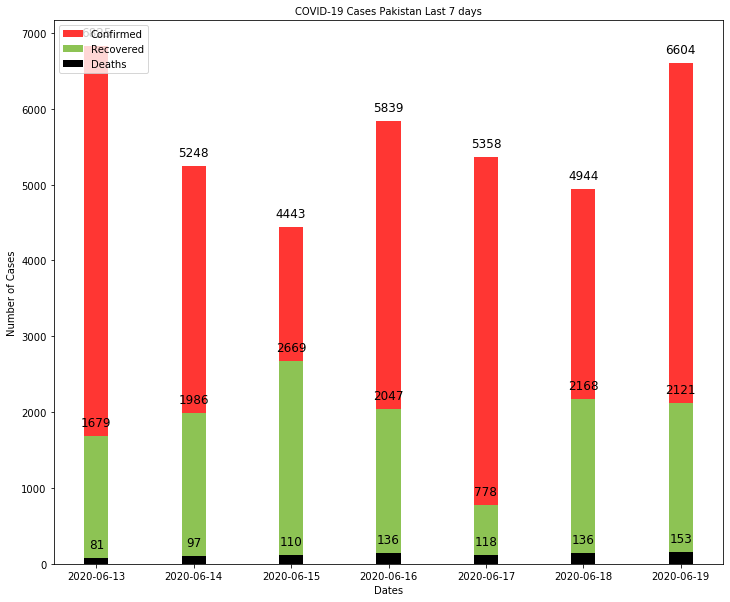

In [65]:
import warnings
warnings.filterwarnings('ignore')
df = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
Covid_Analysis_LastWeek(df)

In [66]:

# import warnings
# warnings.filterwarnings('ignore')
# df = fulltable.groupby("Region")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
# Covid_Analysis_Last24Hours(df)

In [67]:
 #df_t = df[df['Date'] > '2020-04-27']
    
# global fulltable
# df = fulltable[(fulltable['Region'] == 'Punjab')]
# df_t = df.tail(8)
# df_t
# #width = 0.25
#  # Plotting the bars
# fig, ax = plt.subplots(figsize=(12,8))
# df_p = df_t.reset_index().drop('index',axis=1)  
# p_cnfrm_inc = daily_increase(df_p['Confirmed'])
# p_cnfrm_inc = p_cnfrm_inc[1:]
  
# # #---------------------#
# dfs = fulltable[(fulltable['Region'] == 'Sindh')]
# df_t = dfs.tail(8)
# width = 0.25
# df_s = df_t.reset_index().drop('index',axis=1)  
# s_cnfrm_inc = daily_increase(df_s['Confirmed'])
# s_cnfrm_inc = s_cnfrm_inc[1:]
    
# df_p = df_p[1:]
# bar_plot2 = plt.bar(df_p['Date'], s_cnfrm_inc, color = 'lime', width=0.25, align = 'center')
# bar_plot = plt.bar(df_p['Date'], p_cnfrm_inc, color = 'cornflowerblue', width=0.25, align = 'center')

# # bar_plot3 = plt.bar(df_pk['Date'], pr_fat_inc, color = 'r', width=0.25, align = 'center')
# autolabel(bar_plot)
# autolabel(bar_plot2)
# #autolabel(bar_plot3)
# plt.title('COVID-19 Cases {} Last 7 days'.format('Pakistan'), size=10)
# plt.xlabel('Dates', size=10)
# plt.ylabel('Number of Cases', size=10)
# plt.xticks(size=10)
# plt.yticks(size=10)
# plt.legend(['Punjab', 'Sindh'], loc='upper left')
# plt.show()

__Provincial Weekly Analysis, PAKISTAN__

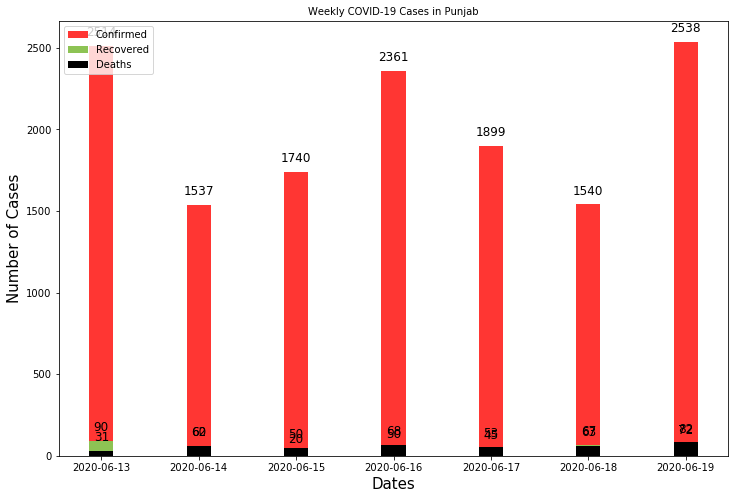

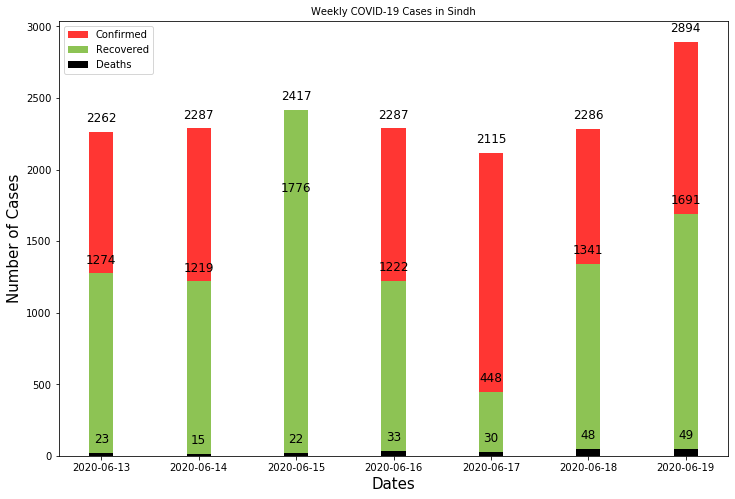

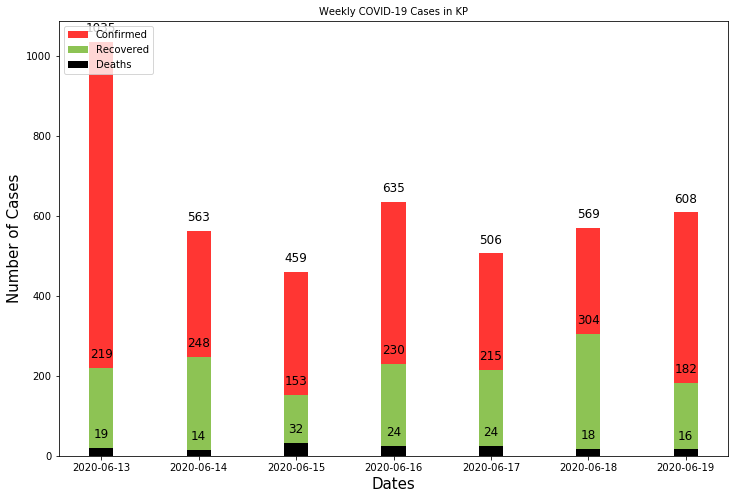

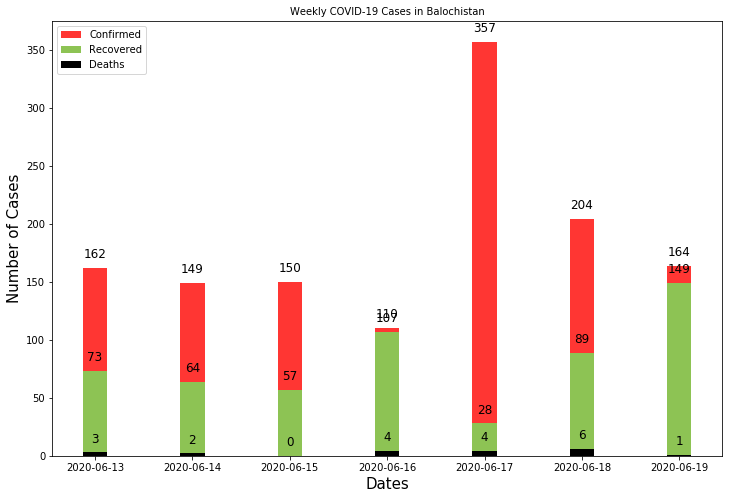

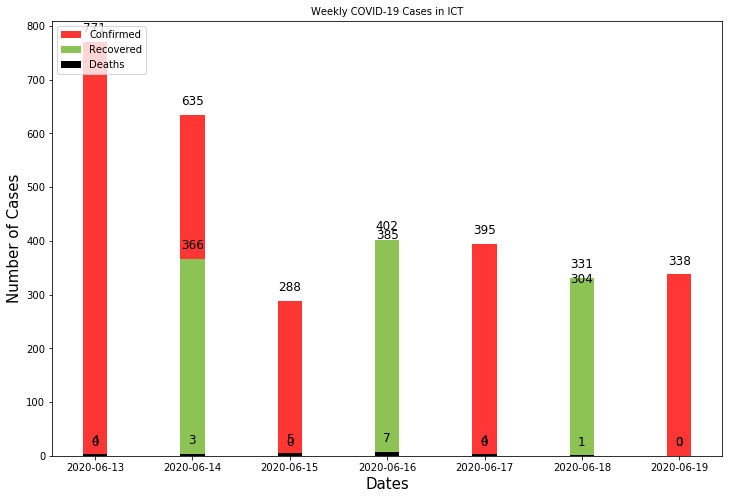

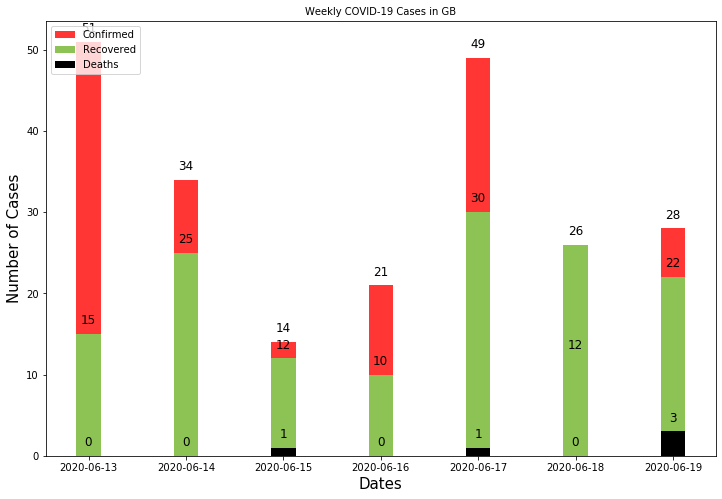

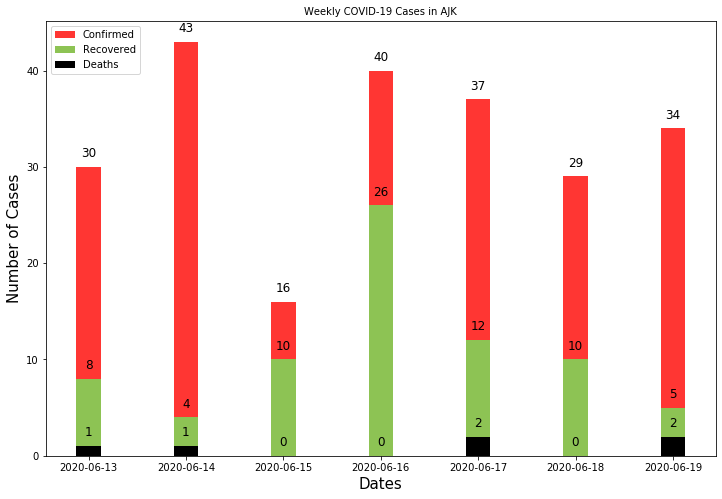

In [68]:
def Covid_Analysis_LastWeek_pr(df, province):
    df_t = df.tail(8)
    width = 0.25
    # Plotting the bars
    fig, ax = plt.subplots(figsize=(12,8))
    df_pk = df_t.reset_index().drop('index',axis=1)  
    pr_cnfrm_inc = daily_increase(df_pk['Confirmed'])
    pr_cnfrm_inc = pr_cnfrm_inc[1:]
    #pos = list(range(len(pr_cnfrm_inc['Confirmed'])))
    pr_fat_inc = daily_increase(df_pk['Deaths'])
    pr_fat_inc = pr_fat_inc[1:]
    pr_recov_inc = daily_increase(df_pk['Recovered'])
    pr_recov_inc = pr_recov_inc[1:]

    df_pk = df_pk[1:]
    bar_plot = plt.bar(df_pk['Date'], pr_cnfrm_inc, color = '#FF3633', width=0.25, align = 'center')
    bar_plot2 = plt.bar(df_pk['Date'], pr_recov_inc, color = '#8dc354', width=0.25, align = 'center')
    bar_plot3 = plt.bar(df_pk['Date'], pr_fat_inc, color = '#000000', width=0.25, align = 'center')
    autolabel(bar_plot)
    autolabel(bar_plot2)
    autolabel(bar_plot3)
    plt.title('Weekly COVID-19 Cases in {}'.format(province), size=10)
    plt.xlabel('Dates', size=15)
    plt.ylabel('Number of Cases', size=15)
    plt.xticks(size=10)
    plt.yticks(size=10)
    plt.legend(['Confirmed', 'Recovered', 'Deaths'], loc='upper left')
    plt.show()

provinces = ['Punjab', 'Sindh', 'KP', 'Balochistan', 'ICT', 'GB','AJK']
#provinces = ['Punjab']
for province in provinces:
    df = get_time_series_province(province)
    Covid_Analysis_LastWeek_pr(df, province)    
    
    

__Pakistan Weekly Increase__

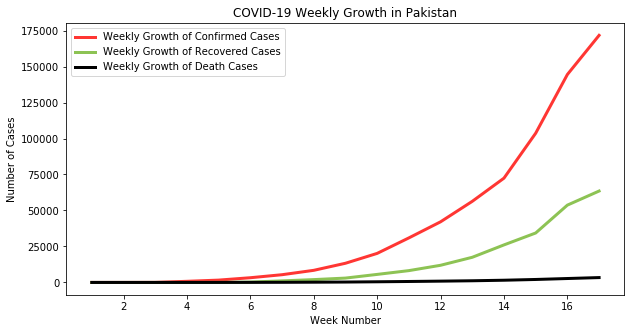

In [69]:
predgrp = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
pak_datewise=fulltable.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
pak_datewise["WeekofYear"]=pak_datewise.index.weekofyear
pak_datewise

week_num_pak=[]
pak_weekwise_confirmed=[]
pak_weekwise_recovered=[]
pak_weekwise_deaths=[]
w=1
for i in list(pak_datewise["WeekofYear"].unique()):
    pak_weekwise_confirmed.append(pak_datewise[pak_datewise["WeekofYear"]==i]["Confirmed"].iloc[-1])
    pak_weekwise_recovered.append(pak_datewise[pak_datewise["WeekofYear"]==i]["Recovered"].iloc[-1])
    pak_weekwise_deaths.append(pak_datewise[pak_datewise["WeekofYear"]==i]["Deaths"].iloc[-1])
    week_num_pak.append(w)
    w=w+1
    
plt.figure(figsize=(10,5))
plt.plot(week_num_pak,pak_weekwise_confirmed,linewidth=3,label="Weekly Growth of Confirmed Cases",  color = '#FF3633')
plt.plot(week_num_pak,pak_weekwise_recovered,linewidth=3,label="Weekly Growth of Recovered Cases",color = '#8dc354')
plt.plot(week_num_pak,pak_weekwise_deaths,linewidth=3,label="Weekly Growth of Death Cases", color = '#000000')
plt.xlabel('Week Number')
plt.ylabel("Number of Cases")
plt.title("COVID-19 Weekly Growth in Pakistan")
plt.legend()    

__COVID-19 Pakistan Weekly Analysis__

Average weekly increase in number of Confirmed Cases 10098.0
Average weekly increase in number of Recovered Cases 3736.0
Average weekly increase in number of Death Cases 199.0


Text(0.5, 1.0, 'COVID-19 Weekly Increase in Pakistan (Fatalities)')

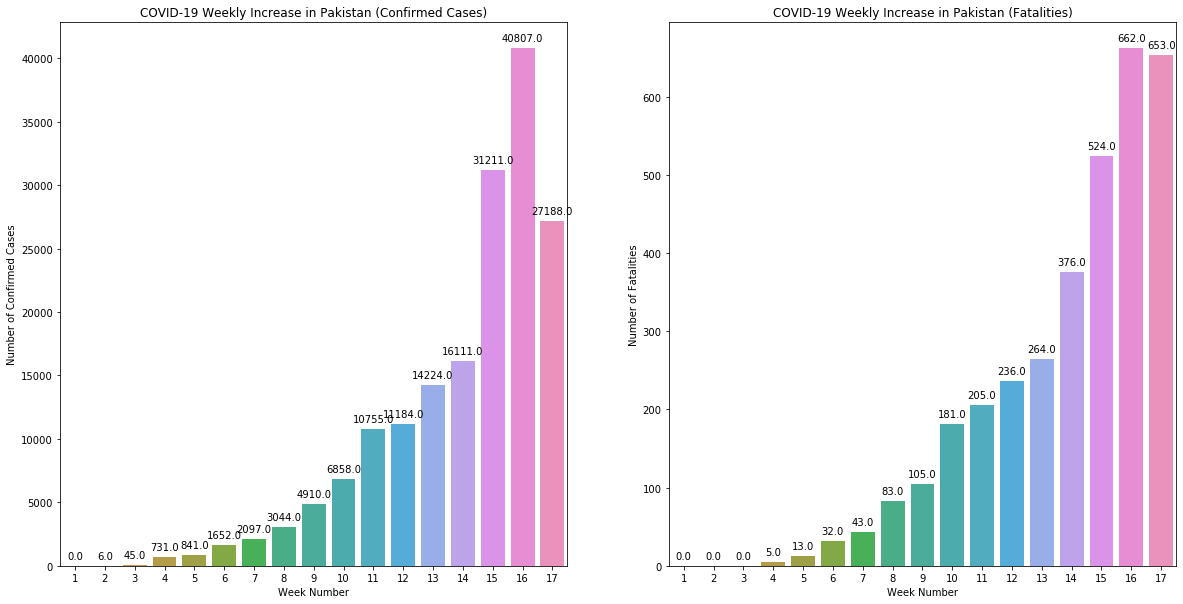

In [70]:
import seaborn as sns
print("Average weekly increase in number of Confirmed Cases",round(pd.Series(pak_weekwise_confirmed).diff().fillna(0).mean()))
print("Average weekly increase in number of Recovered Cases",round(pd.Series(pak_weekwise_recovered).diff().fillna(0).mean()))
print("Average weekly increase in number of Death Cases",round(pd.Series(pak_weekwise_deaths).diff().fillna(0).mean()))

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(20,10))
bar1 = sns.barplot(x=week_num_pak,y=pd.Series(pak_weekwise_confirmed).diff().fillna(0),ax=ax1)
for p in bar1.patches:
    bar1.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

bar2 = sns.barplot(x=week_num_pak,y=pd.Series(pak_weekwise_deaths).diff().fillna(0),ax=ax2)
for p in bar2.patches:
    bar2.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax1.set_xlabel("Week Number")
ax2.set_xlabel("Week Number")
ax1.set_ylabel("Number of Confirmed Cases")
ax2.set_ylabel("Number of Fatalities")
ax1.set_title("COVID-19 Weekly Increase in Pakistan (Confirmed Cases)")
ax2.set_title("COVID-19 Weekly Increase in Pakistan (Fatalities)")

Text(0.5, 1.0, 'COVID-19 Weekly Increase in Pakistan (Confirmed Cases)')

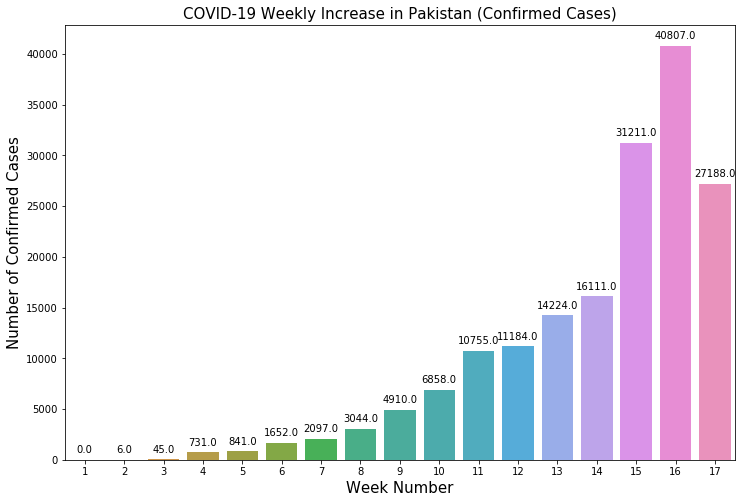

In [71]:
plt.figure(figsize=(12,8))
#sns.set(rc={'figure.figsize':(11.7,8.27)})

bar1 = sns.barplot(x=week_num_pak,y=pd.Series(pak_weekwise_confirmed).diff().fillna(0))
for p in bar1.patches:
    bar1.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xlabel("Week Number", size=15)
plt.ylabel("Number of Confirmed Cases", size=15)
plt.title("COVID-19 Weekly Increase in Pakistan (Confirmed Cases)", size =15)


Text(0.5, 1.0, 'COVID-19 Weekly Increase in Pakistan (Fatalities)')

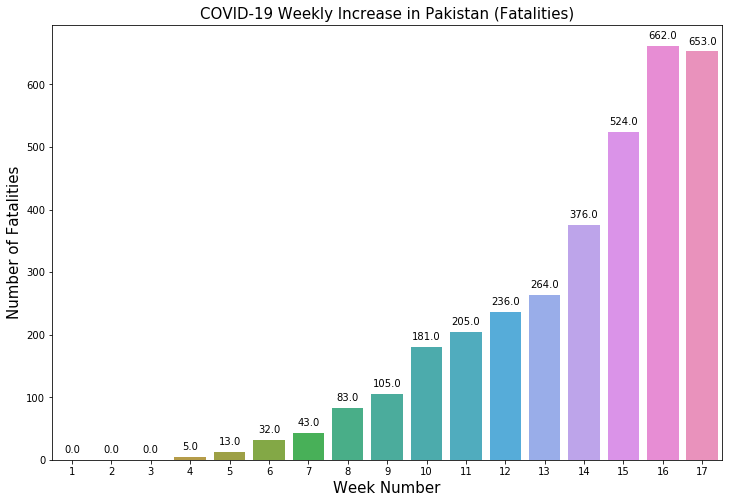

In [72]:
#sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.figure(figsize=(12,8))

bar2 = sns.barplot(x=week_num_pak,y=pd.Series(pak_weekwise_deaths).diff().fillna(0))
for p in bar2.patches:
    bar2.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xlabel("Week Number", size = 15)
plt.ylabel("Number of Fatalities", size = 15)
plt.title("COVID-19 Weekly Increase in Pakistan (Fatalities)", size = 15)

### COVID-19 Pakistan Monthly Growth 

In [73]:
global fulltable

predgrp = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
predgrp['Date'] = pd.to_datetime(predgrp['Date'])
df_t = predgrp[predgrp['Date'] > '2020-03-01']
table = df_t.set_index('Date')
table = table.resample('M').max()
table


Confirmed  Recovered  Deaths
Date                                    
2020-03-31       2039         82      26
2020-04-30      16817       4315     385
2020-05-31      72460      26083    1543
2020-06-30     171666      63504    3382

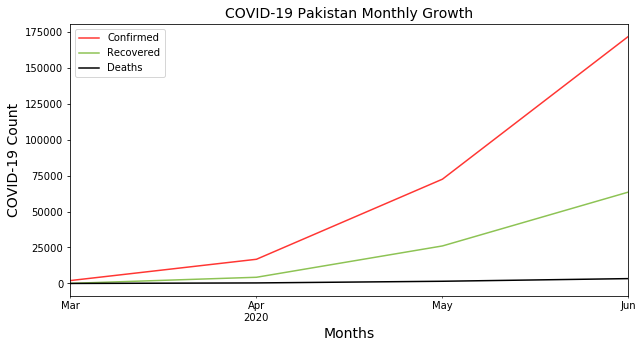

In [74]:
table.plot(figsize=(10,5), color = ['#FF3633','#8dc354','#000000'])
plt.title('COVID-19 Pakistan Monthly Growth', size=14)
plt.xlabel('Months', size=14)
plt.ylabel('COVID-19 Count', size=14 )
plt.show() 

__COVID-19 Pakistan Monthly Growth__

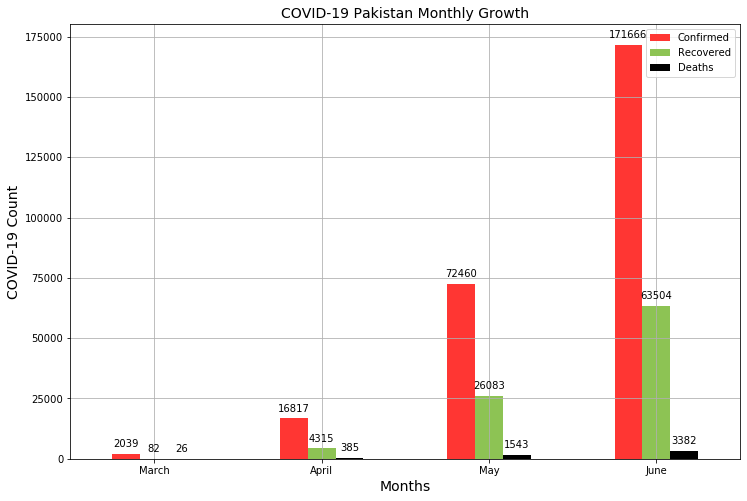

In [75]:
ax = table.plot(kind = 'bar', figsize=(12,8),  color = ['#FF3633','#8dc354','#000000'])
ax.set_xticklabels(['March','April','May', 'June'], rotation=360)
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')    
plt.title('COVID-19 Pakistan Monthly Growth', size=14)
plt.xlabel('Months', size=14)
plt.ylabel('COVID-19 Count', size=14 )
plt.grid() 
plt.show()    

    

__COVID-19 Pakistan Monthly Increase__

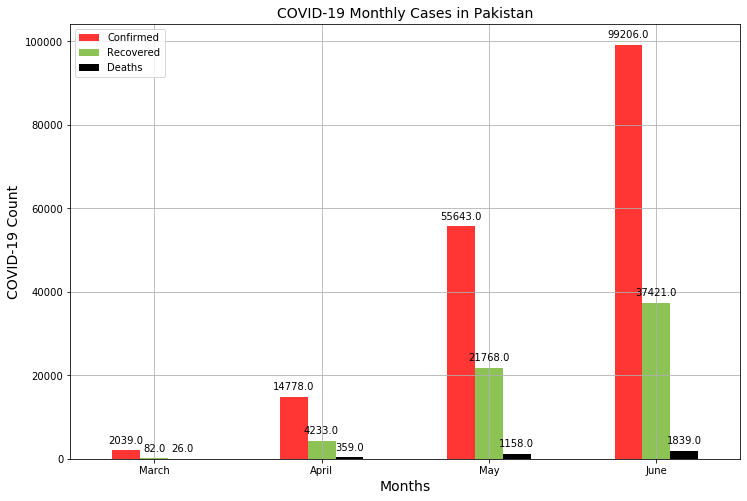

In [77]:
predgrp = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
predgrp['Date'] = pd.to_datetime(predgrp['Date'])
table = predgrp.set_index('Date')
table = table.resample('M').max()
#table = round(pd.Series(table.diff().fillna(0).mean()))
table = table.diff()
table = table.tail(4)
table
ax = table.plot(kind = 'bar', figsize=(12,8),  color = ['#FF3633','#8dc354','#000000'])
ax.set_xticklabels(['March','April','May', 'June'], rotation=360)
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')    
plt.title('COVID-19 Monthly Cases in Pakistan', size=14)
plt.xlabel('Months', size=14)
plt.ylabel('COVID-19 Count', size=14 )
plt.legend(['Confirmed', 'Recovered', 'Deaths'], loc='upper left')
plt.grid() 
plt.show()  



__COVID-19 PAKISTAN TREND__

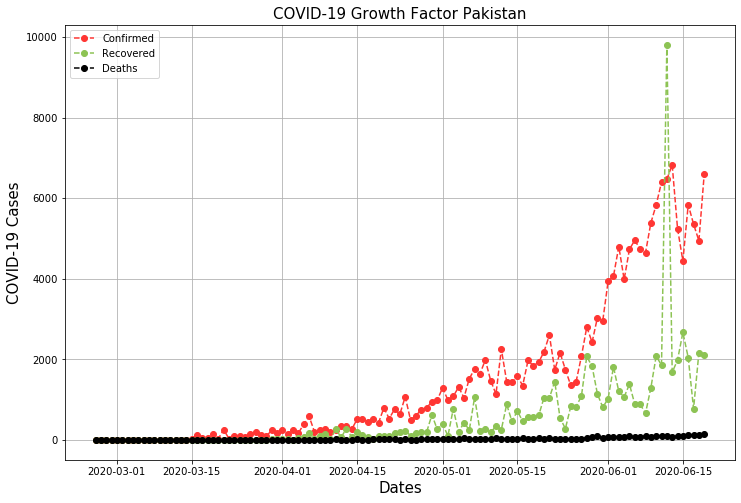

In [78]:
import matplotlib.dates as mdates
predgrp = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()

pk_recov_increase = daily_increase(predgrp['Recovered'])
pk_fat_inc = daily_increase(predgrp['Deaths'])
pk_cnfrm_increase = daily_increase(predgrp['Confirmed'])


plt.figure(figsize=(12, 8))

plot = plt.plot(predgrp['Date'], pk_cnfrm_increase,  color = '#FF3633', marker='o', linestyle='dashed')
plot = plt.plot(predgrp['Date'], pk_recov_increase, color = '#8dc354', marker='o', linestyle='dashed')
plot = plt.plot(predgrp['Date'], pk_fat_inc, color='#000000', marker='o', linestyle='dashed')
#autolabel(bar_plot)
plt.title('COVID-19 Growth Factor {}'.format('Pakistan'), size=15)
plt.xlabel('Dates', size=15)
plt.ylabel('COVID-19 Cases', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(['Confirmed','Recovered','Deaths'])
plt.grid()
plt.show()

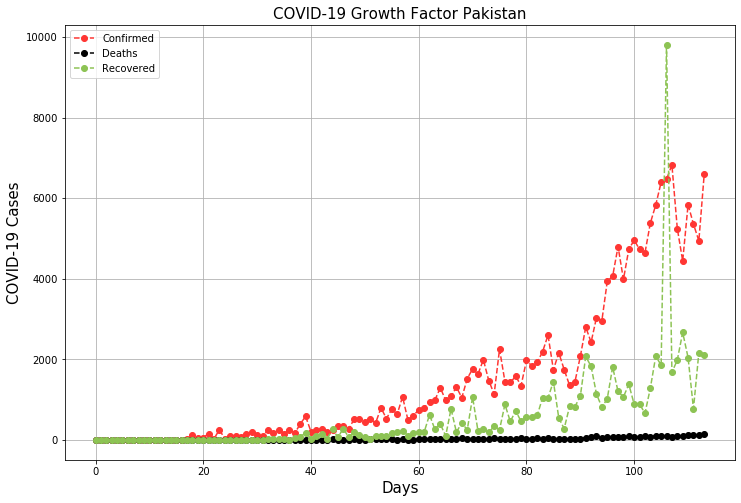

In [79]:
def difference_c(dataset, interval=1):
    index = list(dataset.index)
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset["Confirmed"][i] - dataset["Confirmed"][i - interval]
        diff.append(value)
    return (diff)
def difference_e(dataset, interval=1):
    index = list(dataset.index)
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset["Deaths"][i] - dataset["Deaths"][i - interval]
        diff.append(value)
    return (diff)
def difference_r(dataset, interval=1):
    index = list(dataset.index)
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset["Recovered"][i] - dataset["Recovered"][i - interval]
        diff.append(value)
    return (diff)
#-----------------------------------#
global fulltable

predgrp = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
diffc = difference_c(predgrp )
diffe = difference_e(predgrp )
diffr = difference_r(predgrp )
plt.figure(figsize= (12,8))
plt.plot(diffc,  color = '#FF3633', marker='o', linestyle='dashed')
plt.plot(diffe, color = '#000000', marker='o', linestyle='dashed')
plt.plot(diffr, color = '#8dc354', marker='o', linestyle='dashed')

plt.title("COVID-19 Growth Factor Pakistan",size=15)
plt.xlabel('Days',size=15)
plt.ylabel('COVID-19 Cases',size=15)
plt.legend(['Confirmed','Deaths','Recovered'])
plt.grid()
plt.show()

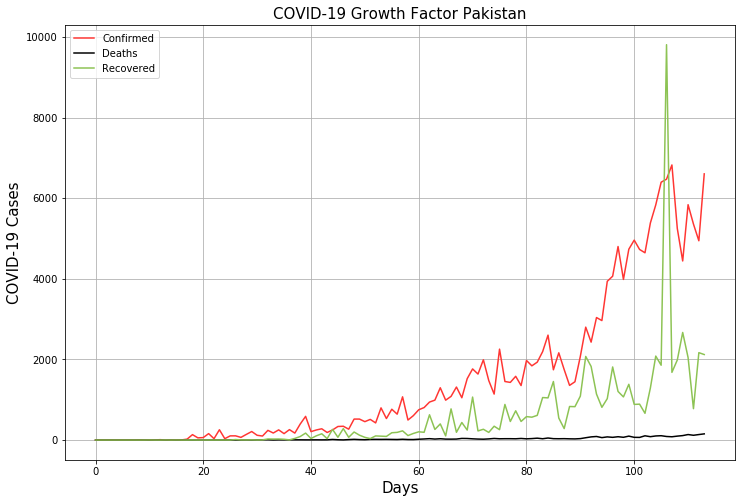

In [80]:
def difference_c(dataset, interval=1):
    index = list(dataset.index)
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset["Confirmed"][i] - dataset["Confirmed"][i - interval]
        diff.append(value)
    return (diff)
def difference_e(dataset, interval=1):
    index = list(dataset.index)
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset["Deaths"][i] - dataset["Deaths"][i - interval]
        diff.append(value)
    return (diff)
def difference_r(dataset, interval=1):
    index = list(dataset.index)
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset["Recovered"][i] - dataset["Recovered"][i - interval]
        diff.append(value)
    return (diff)
#-----------------------------------#
global fulltable

predgrp = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
diffc = difference_c(predgrp )
diffe = difference_e(predgrp )
diffr = difference_r(predgrp )
plt.figure(figsize= (12,8))
plt.plot(diffc,  color = '#FF3633')
plt.plot(diffe, color = '#000000')
plt.plot(diffr, color = '#8dc354')
plt.title("COVID-19 Growth Factor Pakistan",size=15)
plt.xlabel('Days',size=15)
plt.ylabel('COVID-19 Cases',size=15)
plt.legend(['Confirmed','Deaths','Recovered'])
plt.grid()
plt.show()

## PROPHET

__Pakistan National Forecast using Prophet__

In [81]:
global fulltable

predgrp = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
pred_cnfrm = predgrp.loc[:,["Date","Confirmed"]]
pred_exp = predgrp.loc[:,["Date","Deaths"]]

c_data = pred_cnfrm
e_data = pred_exp

c_data.columns = ['ds','y']
e_data.columns = ['ds','y']

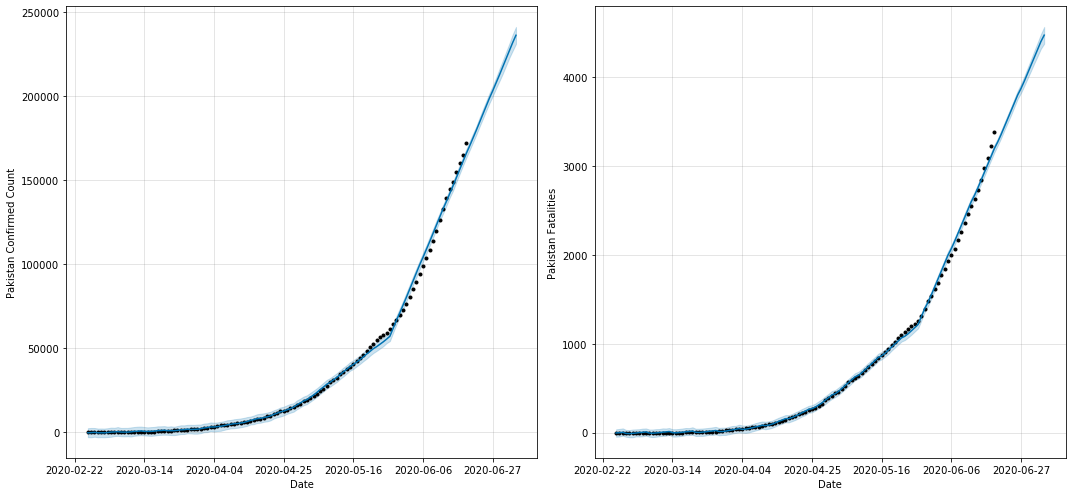

In [82]:

# Confirm Count
mc = Prophet(daily_seasonality=True)
mc.fit(c_data)
future_c = mc.make_future_dataframe(periods=15)
forecast_c = mc.predict(future_c)
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,7))
#py.init_notebook_mode()
fig1 = mc.plot(forecast_c,xlabel='Date',ylabel='Pakistan Confirmed Count', ax=ax1)
# Detecting Trend Change ponits
#add_changepoints_to_plot(fig1.gca(), mc, forecast_c)

# Expiry Count
me = Prophet(daily_seasonality=True)
me.fit(e_data)
future_e = me.make_future_dataframe(periods=15)
forecast_e = me.predict(future_e)
#py.init_notebook_mode()
fig2 = me.plot(forecast_e,xlabel='Date',ylabel='Pakistan Fatalities',ax=ax2)
# Detecting Trend Change ponits
#a2 = add_changepoints_to_plot(fig2.gca(), me, forecast_e)




__Prophet Provincial Model__

In [83]:
def prophet_prov_forecast(df, province):
    predgrp = df.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
    pred_cnfrm = predgrp.loc[:,["Date","Confirmed"]]
    pred_exp = predgrp.loc[:,["Date","Deaths"]]

    c_data = pred_cnfrm
    e_data = pred_exp

    c_data.columns = ['ds','y']
    e_data.columns = ['ds','y']
        # Confirm Count
    mc = Prophet(daily_seasonality=True)
    mc.fit(c_data)
    future_c = mc.make_future_dataframe(periods=15)
    forecast_c = mc.predict(future_c)
    fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,7))
    #py.init_notebook_mode()
    fig1 = mc.plot(forecast_c,xlabel='Date',ylabel=province +' Confirmed Count', ax=ax1)
    # Detecting Trend Change ponits
#     a1 = add_changepoints_to_plot(fig1.gca(), mc, forecast_c)

    # Expiry Count
    me = Prophet(daily_seasonality=True)
    me.fit(e_data)
    future_e = me.make_future_dataframe(periods=15)
    forecast_e = me.predict(future_e)
    #py.init_notebook_mode()
    fig2 = me.plot(forecast_e,xlabel='Date',ylabel=province + ' Fatalities',ax=ax2)
    # Detecting Trend Change ponits
    #a2 = add_changepoints_to_plot(fig2.gca(), me, forecast_e)


In [84]:
def get_time_series_province_pr(province):
    global fulltable
    df = fulltable[(fulltable['Region'] == province)]
    return df

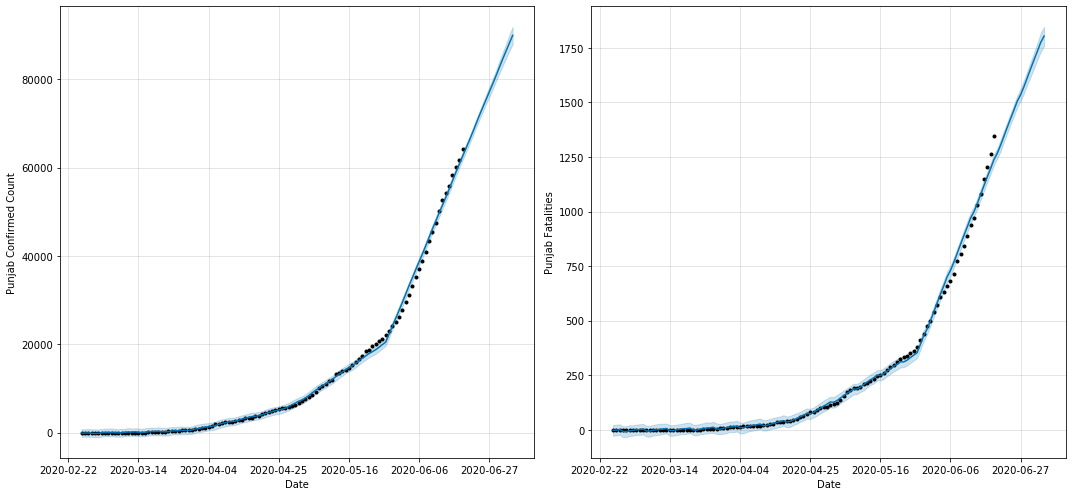

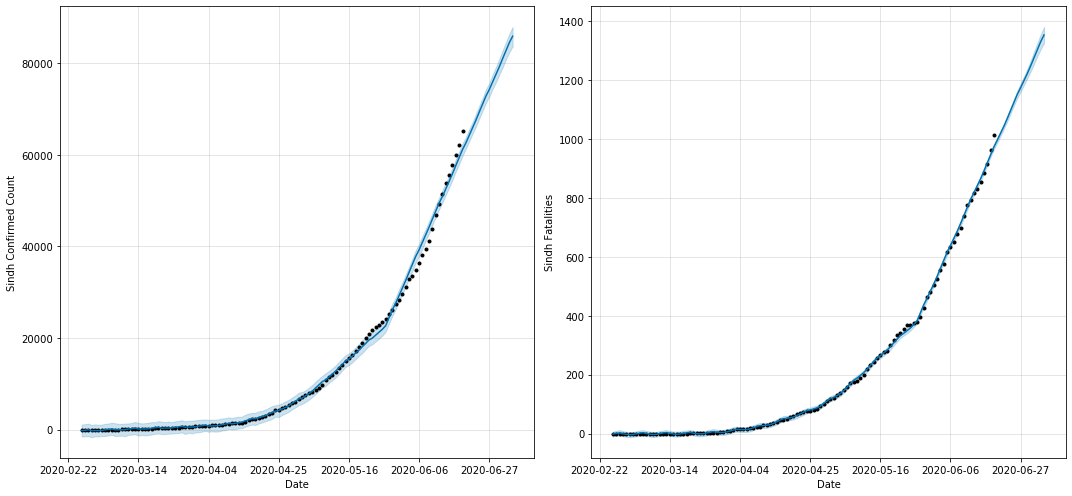

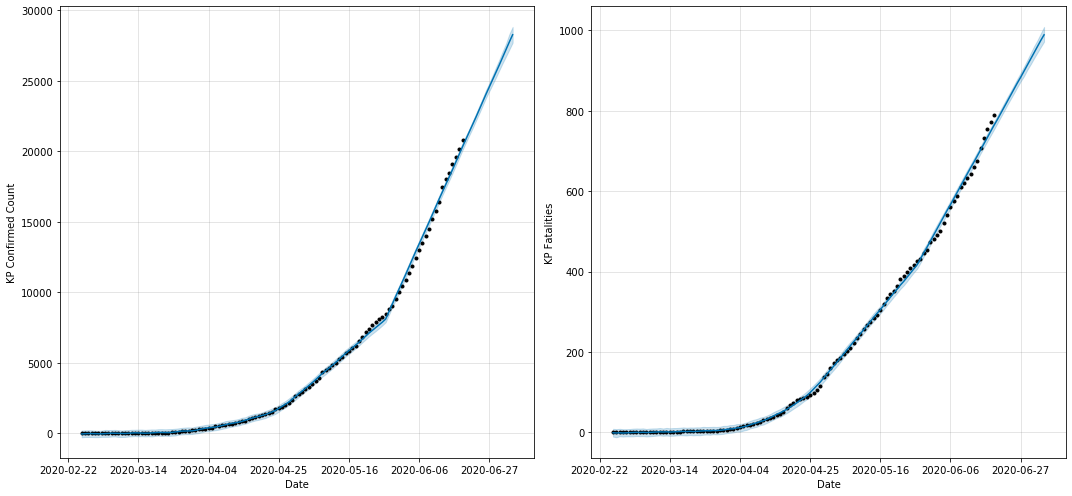

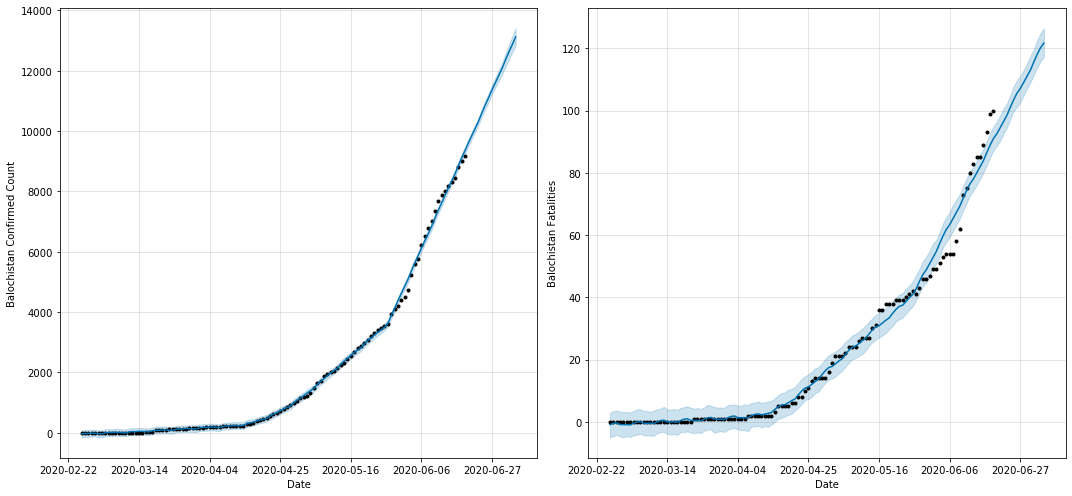

In [85]:
import warnings
warnings.filterwarnings('ignore')

provinces = ['Punjab', 'Sindh', 'KP', 'Balochistan']
#province = 'Punjab'
for province in provinces:
    df = get_time_series_province_pr(province)
    prophet_prov_forecast(df, province)

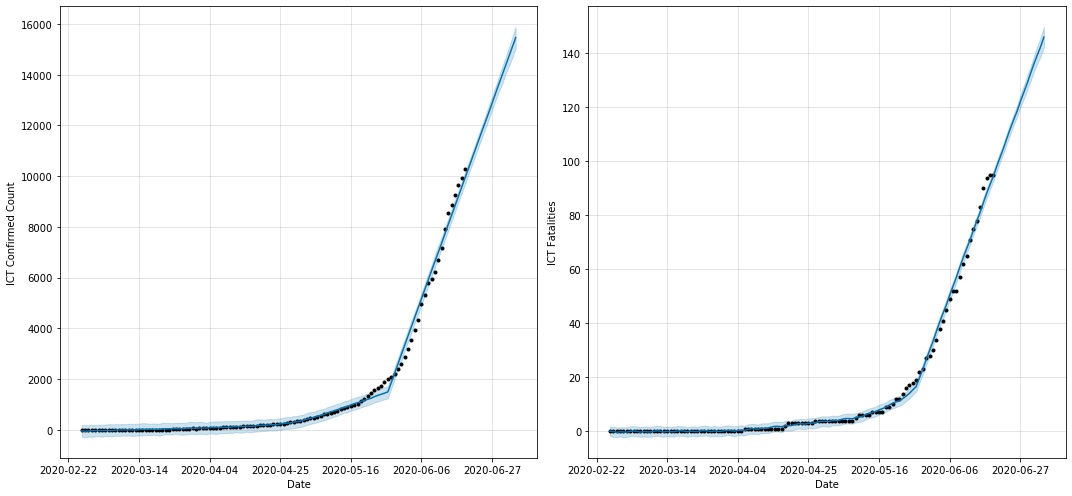

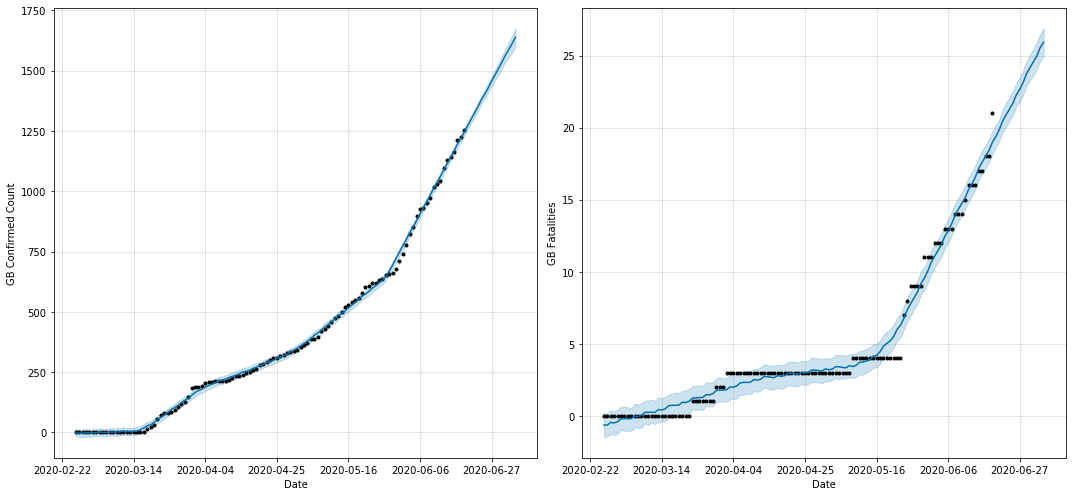

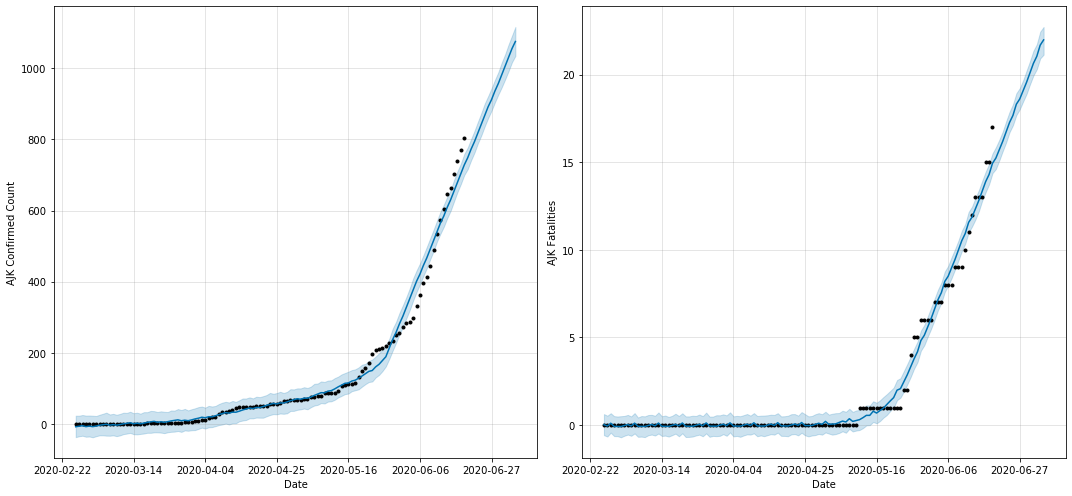

In [86]:
import warnings
warnings.filterwarnings('ignore')

provinces = ['ICT', 'GB', 'AJK']
#province = 'Punjab'
for province in provinces:
    df = get_time_series_province_pr(province)
    prophet_prov_forecast(df, province)

__Prophet National Model__

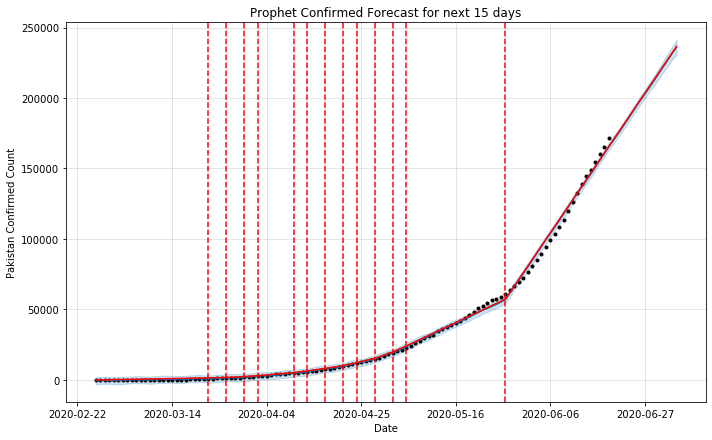

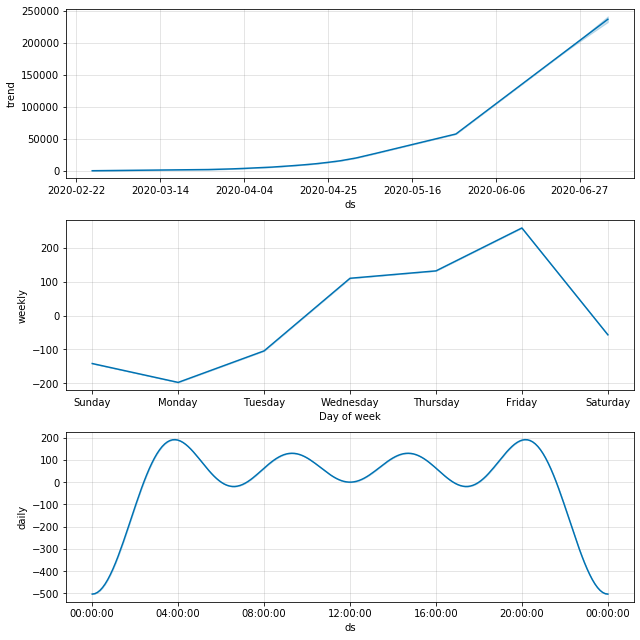

In [87]:
# Confirm Count
mc = Prophet(daily_seasonality=True)
mc.fit(c_data)
future_c = mc.make_future_dataframe(periods=15)
forecast_c = mc.predict(future_c)
#py.init_notebook_mode()
fig1 = mc.plot(forecast_c,xlabel='Date',ylabel='Pakistan Confirmed Count')
axes = fig1.get_axes()
axes[0].set_title('Prophet Confirmed Forecast for next 15 days', size=12)
# Detecting Trend Change ponits
a = add_changepoints_to_plot(fig1.gca(), mc, forecast_c)
fig2 = mc.plot_components(forecast_c)

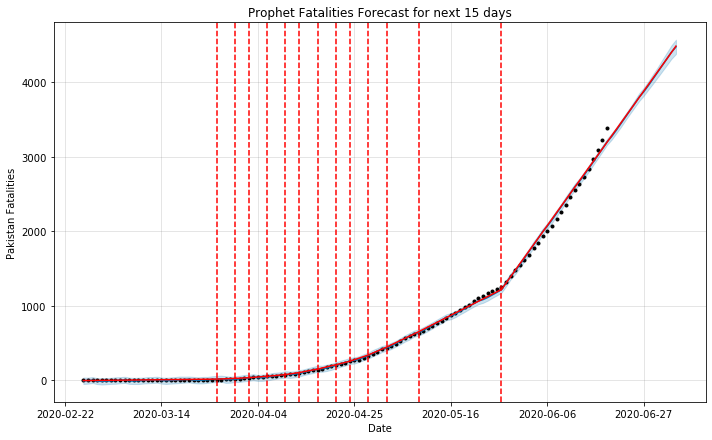

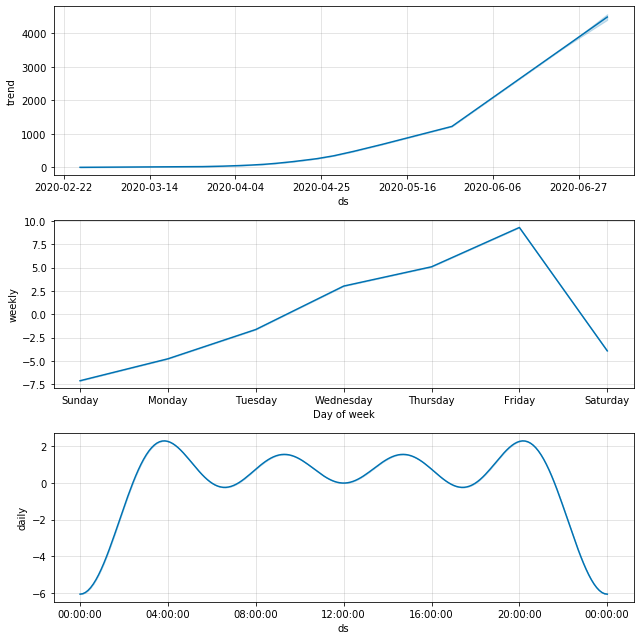

In [88]:
# Expiry Count
me = Prophet(daily_seasonality=True)
me.fit(e_data)
future_e = me.make_future_dataframe(periods=15)
forecast_e = me.predict(future_e)
#py.init_notebook_mode()
fig1 = me.plot(forecast_e,xlabel='Date',ylabel='Pakistan Fatalities')
axes = fig1.get_axes()
axes[0].set_title('Prophet Fatalities Forecast for next 15 days', size=12)
# Detecting Trend Change ponits
a = add_changepoints_to_plot(fig1.gca(), me, forecast_e)
fig2 = me.plot_components(forecast_e)

## ARIMA (Auto-Regressive Integrated Moving Average)

__Pakistan National Forecast using ARIMA__

In [89]:
import datetime
from statsmodels.tsa.arima_model import ARIMA


In [90]:
global fulltable

predgrp = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
pred_cnfrm = predgrp.loc[:,["Date","Confirmed"]]
pr_data = pred_cnfrm
pr_data.columns = ['ds','y']

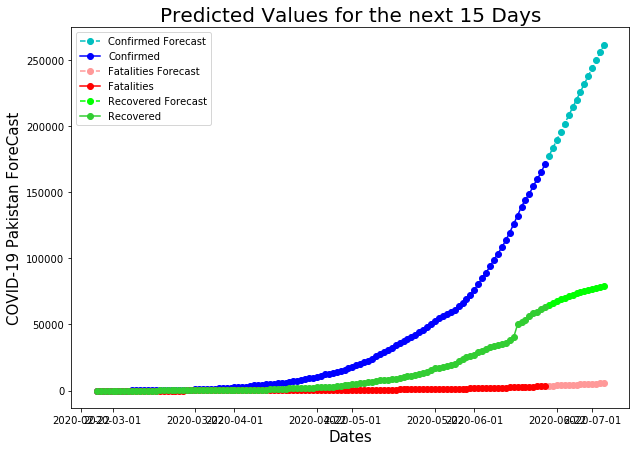

In [91]:
import warnings
warnings.filterwarnings('ignore')
global fulltable

predgrp = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
# Confirm Cases
pred_cnfrm = predgrp.loc[:,["Date","Confirmed"]]
pr_data_c = pred_cnfrm
pr_data_c.columns = ['ds','y']
# Model Confirm
arima_c = ARIMA(pr_data_c['y'], order=(5, 1, 0))
arima_c = arima_c.fit(trend='c', full_output=True, disp=True)
forecast_c = arima_c.forecast(steps= 15)
pred_c = list(forecast_c[0])

# Expired Cases
pred_exp = predgrp.loc[:,["Date","Deaths"]]
pr_data_e = pred_exp
pr_data_e.columns = ['ds','y']

arima_e = ARIMA(pr_data_e['y'], order=(5, 1, 0))
arima_e = arima_e.fit(trend='c', full_output=True, disp=True)
forecast_e = arima_e.forecast(steps= 15)
pred_e = list(forecast_e[0])

# Recovered Cases
pred_rec = predgrp.loc[:,["Date","Recovered"]]
pr_data_r = pred_rec
pr_data_r.columns = ['ds','y']
# Model
arima_r = ARIMA(pr_data_r['y'], order=(5, 1, 0))
arima_r = arima_r.fit(trend='c', full_output=True, disp=True)
forecast_r = arima_r.forecast(steps= 15)
pred_r = list(forecast_r[0])

# Plot Forecast
start_date = pr_data['ds'].max() 
prediction_dates = []
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
    
plt.figure(figsize= (10,7))
plt.xlabel("Dates",fontsize = 15)
plt.ylabel('COVID-19 Pakistan ForeCast',fontsize = 15)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)

#'#ff9999'-->pink
plt.plot_date(y= pred_c,x= prediction_dates,linestyle ='dashed',color = 'c',label = 'Confirmed Forecast');
plt.plot_date(y=pr_data_c['y'],x=pr_data_c['ds'],linestyle = '-',color = 'blue',label = 'Confirmed');

plt.plot_date(y= pred_e,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Fatalities Forecast');
plt.plot_date(y=pr_data_e['y'],x=pr_data_e['ds'],linestyle = '-',color = 'red',label = 'Fatalities');

plt.plot_date(y= pred_r,x= prediction_dates,linestyle ='dashed',color = 'lime',label = 'Recovered Forecast');
plt.plot_date(y=pr_data_r['y'],x=pr_data_r['ds'],linestyle = '-',color = 'limegreen',label = 'Recovered');

plt.legend();

In [92]:
# import numpy as np
# global predgrp
# ts_log = np.log(fulltable)
# plt.title('Log of the data')
# plt.plot(ts_log)
# plt.show()

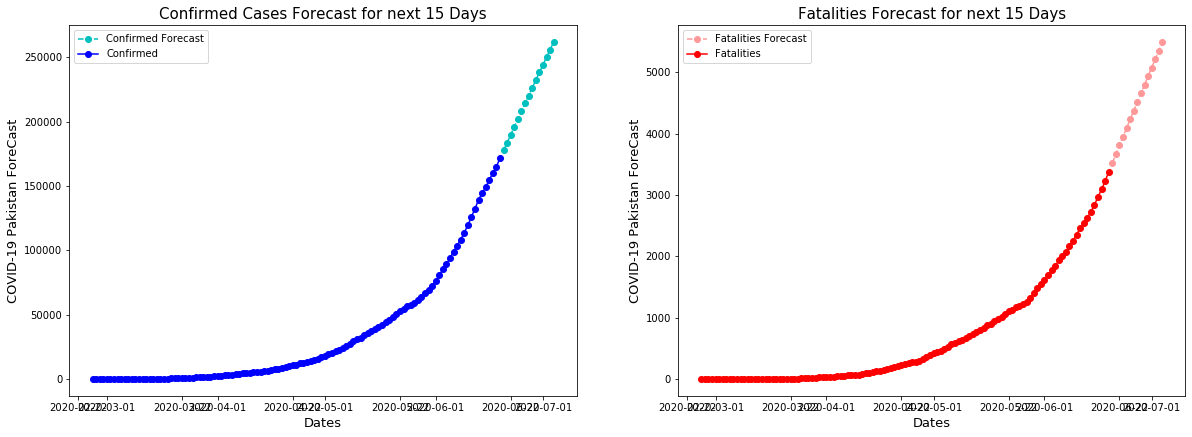

In [93]:
import warnings
warnings.filterwarnings('ignore')
global fulltable

predgrp = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
# Confirm Cases
pred_cnfrm = predgrp.loc[:,["Date","Confirmed"]]
pr_data_c = pred_cnfrm
pr_data_c.columns = ['ds','y']
# Model Confirm
arima_c = ARIMA(pr_data_c['y'], order=(5, 1, 0))
arima_c = arima_c.fit(trend='c', full_output=True, disp=True)
forecast_c = arima_c.forecast(steps= 15)
pred_c = list(forecast_c[0])

# Expired Cases
pred_exp = predgrp.loc[:,["Date","Deaths"]]
pr_data_e = pred_exp
pr_data_e.columns = ['ds','y']

arima_e = ARIMA(pr_data_e['y'], order=(5, 1, 0))
arima_e = arima_e.fit(trend='c', full_output=True, disp=True)
forecast_e = arima_e.forecast(steps= 15)
pred_e = list(forecast_e[0])

# Recovered Cases
pred_rec = predgrp.loc[:,["Date","Recovered"]]
pr_data_r = pred_rec
pr_data_r.columns = ['ds','y']
# Model
arima_r = ARIMA(pr_data_r['y'], order=(5, 1, 0))
arima_r = arima_r.fit(trend='c', full_output=True, disp=True)
forecast_r = arima_r.forecast(steps= 15)
pred_r = list(forecast_r[0])

# Plot Forecast
start_date = pr_data['ds'].max() 
prediction_dates = []
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date

plt.figure(figsize= (20,15))
ax1 = plt.subplot(221)
ax1.plot_date(y= pred_c,x= prediction_dates,linestyle ='dashed',color = 'c' , label = 'Confirmed Forecast');
ax1.plot_date(y=pr_data_c['y'],x=pr_data_c['ds'],linestyle = '-',color = 'b' , label = 'Confirmed');
ax1.set_title("Confirmed Cases Forecast for next 15 Days" , fontsize = 15)
ax1.set_xlabel("Dates",fontsize = 13) 
ax1.set_ylabel('COVID-19 Pakistan ForeCast',fontsize = 13) 
ax1.legend()
ax2 = plt.subplot(222)
ax2.plot_date(y= pred_e,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Fatalities Forecast');
ax2.plot_date(y=pr_data_e['y'],x=pr_data_e['ds'],linestyle = '-',color = 'r',label = 'Fatalities');
ax2.set_title("Fatalities Forecast for next 15 Days" , fontsize = 15)
ax2.set_xlabel("Dates",fontsize = 13) 
ax2.set_ylabel('COVID-19 Pakistan ForeCast',fontsize = 13) 
ax2.legend();

__Confirmed Cases Forecast__

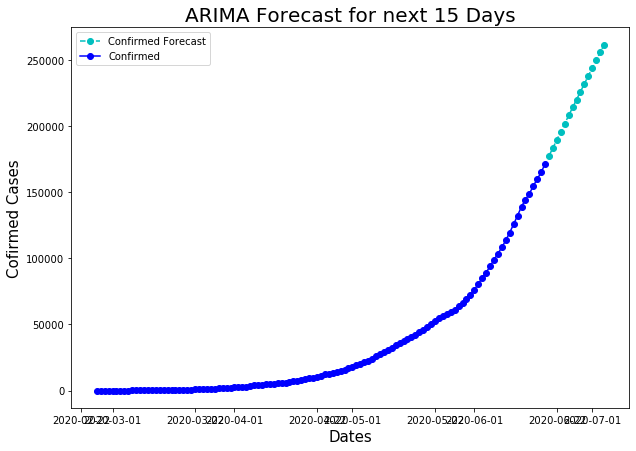

In [94]:
#arima = ARIMA(pr_data['y'], order=(3, 2, 0))
arima = ARIMA(pr_data['y'], order=(5, 1, 0))
arima = arima.fit(trend='c', full_output=True, disp=True)

forecast = arima.forecast(steps= 15)
pred = list(forecast[0])

start_date = pr_data['ds'].max()
prediction_dates = []
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (10,7))
plt.xlabel("Dates",fontsize = 15)
plt.ylabel('Cofirmed Cases',fontsize = 15)
plt.title("ARIMA Forecast for next 15 Days" , fontsize = 20)

#'#ff9999'-->pink
plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = 'c',label = 'Confirmed Forecast');
plt.plot_date(y=pr_data['y'],x=pr_data['ds'],linestyle = '-',color = 'blue',label = 'Confirmed');
plt.legend();


In [95]:
residuals = arima.resid
mae = np.mean(np.abs(residuals))
mae

267.44133252298167

__Fatalities Forecast__

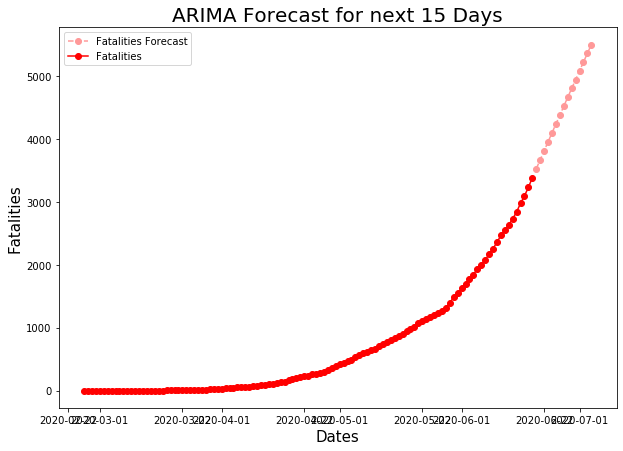

In [96]:
global predgrp
pred_exp = predgrp.loc[:,["Date","Deaths"]]
pr_data = pred_exp
pr_data.columns = ['ds','y']
#arima = ARIMA(pr_data['y'], order=(3, 2,0))
arima = ARIMA(pr_data['y'], order=(5, 1, 0))
arima = arima.fit(trend='c', full_output=True, disp=True)
forecast = arima.forecast(steps= 15)
pred = list(forecast[0])

start_date = pr_data['ds'].max()
prediction_dates = []
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (10,7))
plt.xlabel("Dates",fontsize = 15)
plt.ylabel('Fatalities',fontsize = 15)
plt.title("ARIMA Forecast for next 15 Days" , fontsize = 20)

#'#ff9999'-->pink
plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Fatalities Forecast');
plt.plot_date(y=pr_data['y'],x=pr_data['ds'],linestyle = '-',color = 'red',label = 'Fatalities');
plt.legend();

In [97]:
residuals = arima.resid
mae = np.mean(np.abs(residuals))
mae

6.581015795137436

__Recovered Forecast__

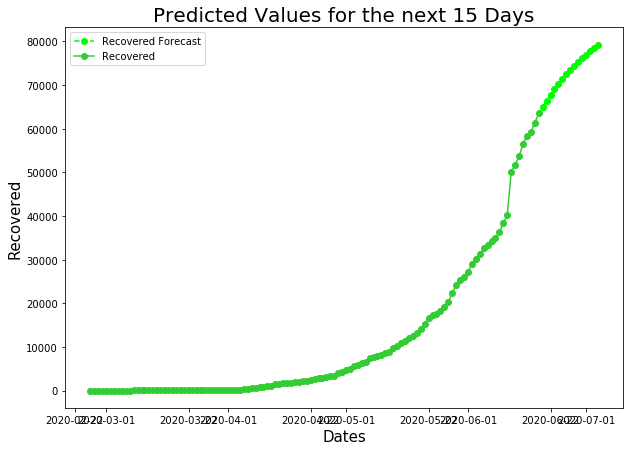

In [98]:
import warnings
warnings.filterwarnings('ignore')
# Recovered Cases
pred_rec = predgrp.loc[:,["Date","Recovered"]]
pr_data_r = pred_rec
pr_data_r.columns = ['ds','y']
# Model
#arima_r = ARIMA(pr_data_r['y'], order=(3, 2, 0))
arima_r = ARIMA(pr_data_r['y'], order=(5, 1, 0))
arima_r = arima_r.fit(trend='c', full_output=True, disp=True)
forecast_r = arima_r.forecast(steps= 15)
pred_r = list(forecast_r[0])

# Plot Forecast
start_date = pr_data_r['ds'].max() 
prediction_dates = []
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
    
plt.figure(figsize= (10,7))
plt.xlabel("Dates",fontsize = 15)
plt.ylabel('Recovered',fontsize = 15)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)

plt.plot_date(y= pred_r ,x= prediction_dates,linestyle ='dashed',color = 'lime',label = 'Recovered Forecast');
plt.plot_date(y=pr_data_r['y'],x=pr_data_r['ds'],linestyle = '-',color = 'limegreen',label = 'Recovered');

plt.legend();

In [99]:
residuals = arima_r.resid
mae = np.mean(np.abs(residuals))
mae

339.75102070574803

__ARIMA : Provincial Model Pakistan__ 

In [100]:
global fulltable

def ARIMA_Prov_old(predgrp, province):
    #predgrp = predgrp.groupby("Date")[["Confirmed","Recovered","Deaths"]]
    # Confirm Cases
    pred_cnfrm = predgrp.loc[:,["Date","Confirmed"]]
    pr_data_c = pred_cnfrm
    pr_data_c.columns = ['ds','y']
    # Model Confirm
    arima_c = ARIMA(pr_data_c['y'], order=(5, 1, 0))
    arima_c = arima_c.fit(trend='c', full_output=True, disp=True)
    forecast_c = arima_c.forecast(steps= 15)
    pred_c = list(forecast_c[0])

    # Expired Cases
    pred_exp = predgrp.loc[:,["Date","Deaths"]]
    pr_data_e = pred_exp
    pr_data_e.columns = ['ds','y']

    arima_e = ARIMA(pr_data_e['y'], order=(5, 1, 0))
    arima_e = arima_e.fit(trend='c', full_output=True, disp=True)
    forecast_e = arima_e.forecast(steps= 15)
    pred_e = list(forecast_e[0])

    # Recovered Cases
    pred_rec = predgrp.loc[:,["Date","Recovered"]]
    pr_data_r = pred_rec
    pr_data_r.columns = ['ds','y']
    # Model
    arima_r = ARIMA(pr_data_r['y'], order=(5, 1, 0))
    arima_r = arima_r.fit(trend='c', full_output=True, disp=True)
    forecast_r = arima_r.forecast(steps= 15)
    pred_r = list(forecast_r[0])

    # Plot Forecast
    start_date = pr_data['ds'].max() 
    prediction_dates = []
    for i in range(15):
        date = start_date + datetime.timedelta(days=1)
        prediction_dates.append(date)
        start_date = date

    plt.figure(figsize= (10,7))
    plt.xlabel("Dates",fontsize = 15)
    plt.ylabel('COVID-19 '+ province + ' ForeCast',fontsize = 15)
    plt.title("ARIMA MODEL(Predicted Values for the next 15 Days)" , fontsize = 20)

    #'#ff9999'-->pink
    plt.plot_date(y= pred_c,x= prediction_dates,linestyle ='dashed',color = 'c',label = 'Confirmed Forecast');
    plt.plot_date(y=pr_data_c['y'],x=pr_data_c['ds'],linestyle = '-',color = 'blue',label = 'Confirmed');

    plt.plot_date(y= pred_e,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Fatalities Forecast');
    plt.plot_date(y=pr_data_e['y'],x=pr_data_e['ds'],linestyle = '-',color = 'red',label = 'Fatalities');

    plt.plot_date(y= pred_r,x= prediction_dates,linestyle ='dashed',color = 'lime',label = 'Recovered Forecast');
    plt.plot_date(y=pr_data_r['y'],x=pr_data_r['ds'],linestyle = '-',color = 'limegreen',label = 'Recovered');

    plt.legend();

In [101]:
global fulltable

def ARIMA_Prov(predgrp, province):
    #predgrp = predgrp.groupby("Date")[["Confirmed","Recovered","Deaths"]]
    # Confirm Cases
    pred_cnfrm = predgrp.loc[:,["Date","Confirmed"]]
    pr_data_c = pred_cnfrm
    pr_data_c.columns = ['ds','y']
    # Model Confirm
    arima_c = ARIMA(pr_data_c['y'], order=(5, 1, 0))
    arima_c = arima_c.fit(trend='c', full_output=True, disp=True)
    forecast_c = arima_c.forecast(steps= 15)
    pred_c = list(forecast_c[0])

    # Expired Cases
    pred_exp = predgrp.loc[:,["Date","Deaths"]]
    pr_data_e = pred_exp
    pr_data_e.columns = ['ds','y']

    arima_e = ARIMA(pr_data_e['y'], order=(5, 1, 0))
    arima_e = arima_e.fit(trend='c', full_output=True, disp=True)
    forecast_e = arima_e.forecast(steps= 15)
    pred_e = list(forecast_e[0])

#     # Recovered Cases
#     pred_rec = predgrp.loc[:,["Date","Recovered"]]
#     pr_data_r = pred_rec
#     pr_data_r.columns = ['ds','y']
#     # Model
#     arima_r = ARIMA(pr_data_r['y'], order=(5, 1, 0))
#     arima_r = arima_r.fit(trend='c', full_output=True, disp=True)
#     forecast_r = arima_r.forecast(steps= 15)
#     pred_r = list(forecast_r[0])

    # Plot Forecast
    start_date = pr_data['ds'].max() 
    prediction_dates = []
    for i in range(15):
        date = start_date + datetime.timedelta(days=1)
        prediction_dates.append(date)
        start_date = date

    plt.figure(figsize= (20,15))
    ax1 = plt.subplot(221)
    ax1.plot_date(y= pred_c,x= prediction_dates,linestyle ='dashed',color = 'c' , label = 'Confirmed Forecast');
    ax1.plot_date(y=pr_data_c['y'],x=pr_data_c['ds'],linestyle = '-',color = 'b' , label = 'Confirmed');
    ax1.set_title("Confirmed Cases Forecast for next 15 Days" , fontsize = 15)
    ax1.set_xlabel("Dates",fontsize = 13) 
    ax1.set_ylabel('COVID-19 '+province+' ForeCast',fontsize = 13) 
    ax1.legend()
    ax2 = plt.subplot(222)
    ax2.plot_date(y= pred_e,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Fatalities Forecast');
    ax2.plot_date(y=pr_data_e['y'],x=pr_data_e['ds'],linestyle = '-',color = 'r',label = 'Fatalities');
    ax2.set_title("Fatalities Forecast for next 15 Days" , fontsize = 15)
    ax2.set_xlabel("Dates",fontsize = 13) 
    ax2.set_ylabel('COVID-19 '+province+' ForeCast',fontsize = 13) 
    ax2.legend();


In [102]:
def get_time_series_province_pr(province):
    global fulltable
    df = fulltable[(fulltable['Region'] == province)]
    return df

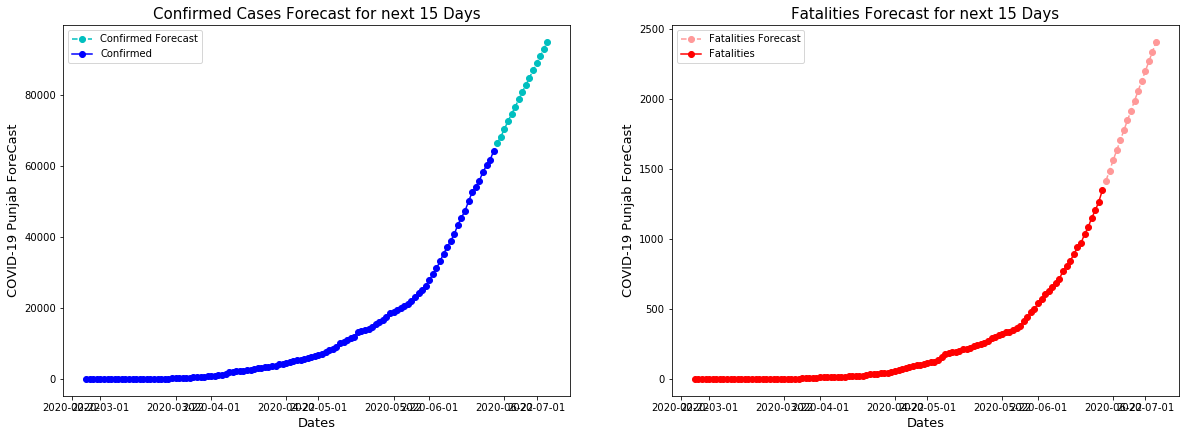

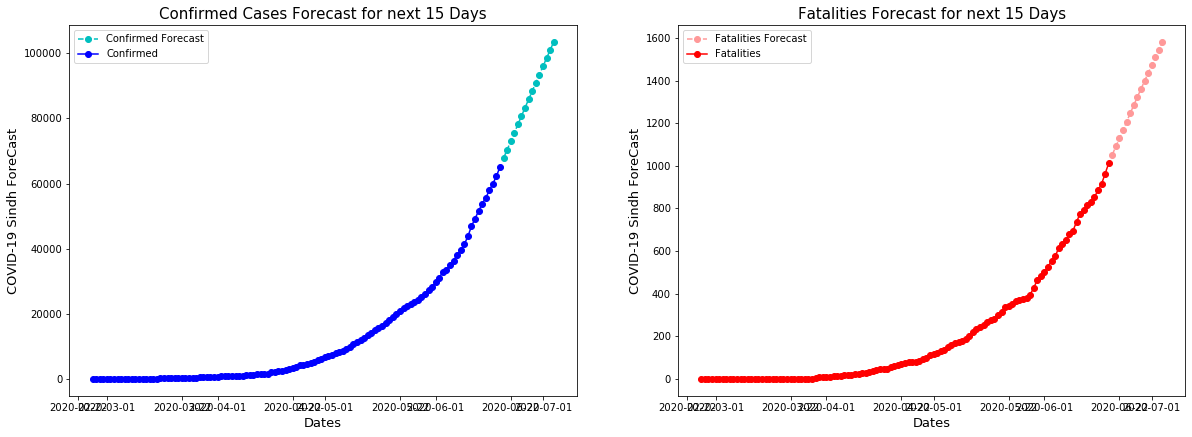

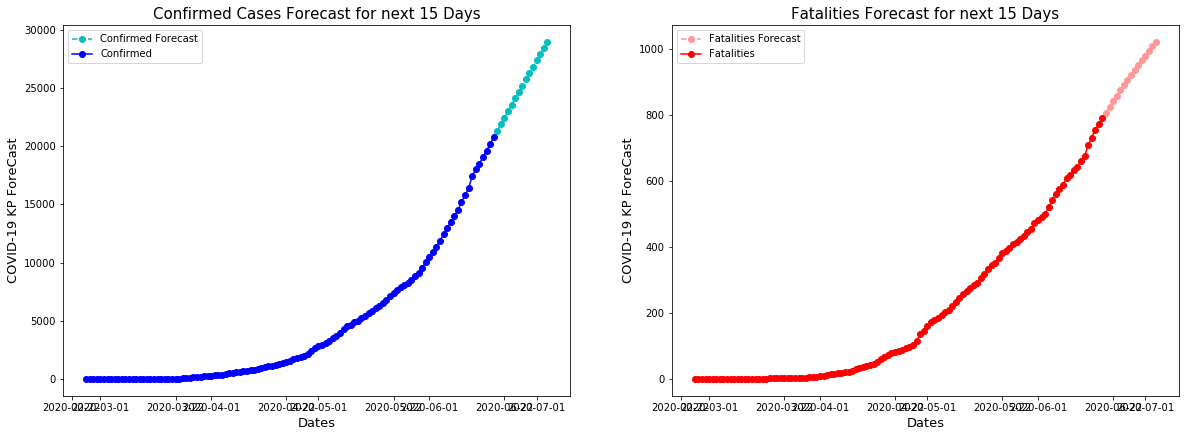

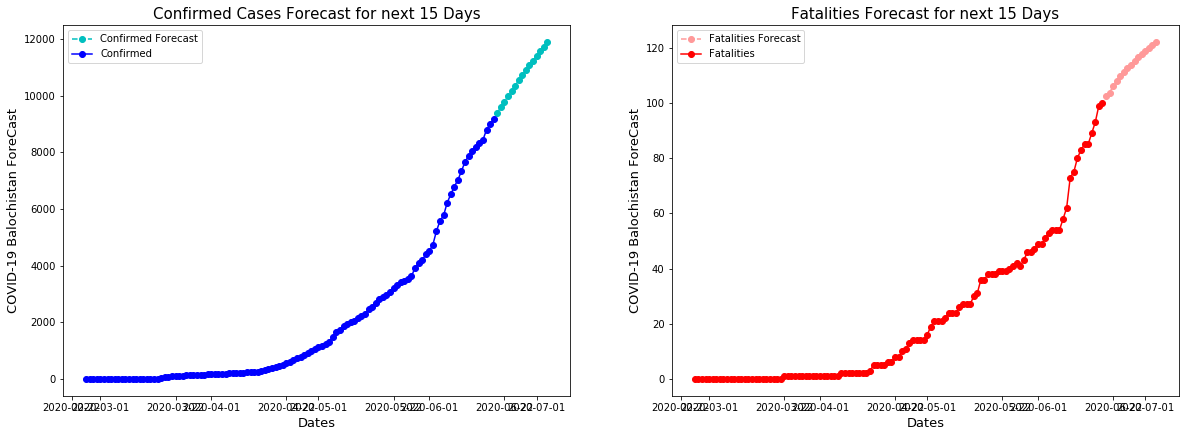

In [103]:
import warnings
warnings.filterwarnings('ignore')

provinces = ['Punjab', 'Sindh', 'KP', 'Balochistan']
#province = 'Punjab'
for province in provinces:
    df = get_time_series_province_pr(province)
    ARIMA_Prov(df, province)
   # ARIMA_Prov_old(df, province)

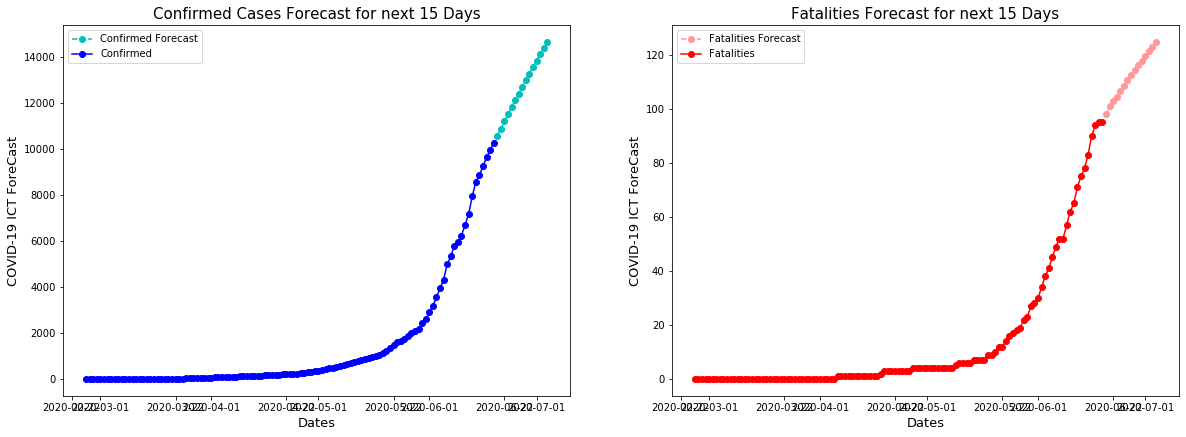

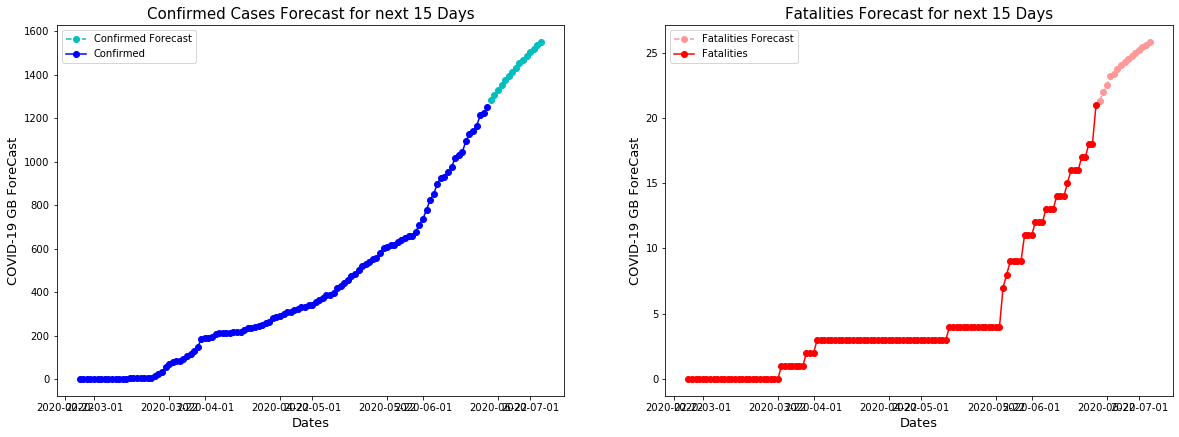

In [104]:
import warnings
warnings.filterwarnings('ignore')

provinces = ['ICT', 'GB']
#province = 'Punjab'
for province in provinces:
    df = get_time_series_province_pr(province)
    ARIMA_Prov(df, province)

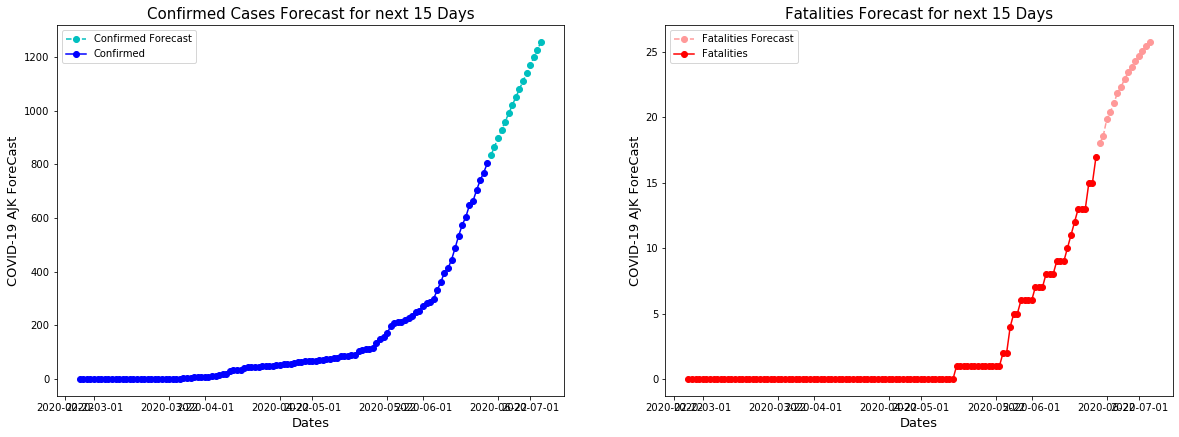

In [105]:
    province = 'AJK'
    predgrp = get_time_series_province_pr(province)
    pred_cnfrm = predgrp.loc[:,["Date","Confirmed"]]
    pr_data_c = pred_cnfrm
    pr_data_c.columns = ['ds','y']
    # Model Confirm
    arima_c = ARIMA(pr_data_c['y'], order=(5, 1, 0))
    arima_c = arima_c.fit(trend='c', full_output=True, disp=True)
    forecast_c = arima_c.forecast(steps= 15)
    pred_c = list(forecast_c[0])
    # Recovered Cases
    pred_rec = predgrp.loc[:,["Date","Deaths"]]
    pr_data_r = pred_rec
    pr_data_r.columns = ['ds','y']
    # Model
    arima_r = ARIMA(pr_data_r['y'], order=(5, 1, 0))
    arima_r = arima_r.fit(trend='c', full_output=True, disp=True)
    forecast_r = arima_r.forecast(steps= 15)
    pred_r = list(forecast_r[0])
    # Plot Forecast
    start_date = pr_data['ds'].max() 
    prediction_dates = []
    for i in range(15):
        date = start_date + datetime.timedelta(days=1)
        prediction_dates.append(date)
        start_date = date

    
    plt.figure(figsize= (20,15))
    ax1 = plt.subplot(221)
    ax1.plot_date(y= pred_c,x= prediction_dates,linestyle ='dashed',color = 'c' , label = 'Confirmed Forecast');
    ax1.plot_date(y=pr_data_c['y'],x=pr_data_c['ds'],linestyle = '-',color = 'b' , label = 'Confirmed');
    ax1.set_title("Confirmed Cases Forecast for next 15 Days" , fontsize = 15)
    ax1.set_xlabel("Dates",fontsize = 13) 
    ax1.set_ylabel('COVID-19 '+province+' ForeCast',fontsize = 13) 
    ax1.legend()
    ax2 = plt.subplot(222)
    ax2.plot_date(y= pred_r,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Fatalities Forecast');
    ax2.plot_date(y=pr_data_r['y'],x=pr_data_r['ds'],linestyle = '-',color = 'red',label = 'Fatalities');
    ax2.set_title("Fatalities Forecast for next 15 Days" , fontsize = 15)
    ax2.set_xlabel("Dates",fontsize = 13) 
    ax2.set_ylabel('COVID-19 '+province+' ForeCast',fontsize = 13) 
    ax2.legend();

## Model: Forecast using Gradient with Diffusion

I am using a model from a __marketing__ paper by __Emmanuelle Le Nagard__ and __Alexandre Steyer__, that attempts to reflect the social structure of a __diffusion__ process.

### Packages

In [155]:
import numpy as np
import pandas as pd
import datetime

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [156]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

COVID-19 Data Modeling for Pakistan

#### Province wise Data Model

In [221]:
import requests
import io

# Username of GitHub account

username = 'abdulbarimalik'

# Personal Access Token (PAO) from GitHub account

token = 'a5389dd2ed961708e248000815bfb4a638f2b6e8'

# Creates a re-usable session object with creds in-built

github_session = requests.Session()
github_session.auth = (username, token)
    
# Downloading the csv file from GitHub

url = "https://raw.githubusercontent.com/abdulbarimalik/COVID19/master/Covid-19-PAK.csv?token=AB6MNPZN2XR4SASSW4JSSO26YS46Q" # Make sure the url is the raw version of the file on GitHub
download = github_session.get(url).content

# Reading the downloaded content and making it a pandas dataframe

fulltable_pr = pd.read_csv(io.StringIO(download.decode('utf-8')))


In [222]:
#fulltable_pr = pd.read_excel('F:/Data Sets/COVID-19/Pakistan/time series/COVID-19_DATA.xlsx', sheet_name='TimeSeries_KeyIndicators')
fulltable_pr = fulltable_pr.drop(['Discharged'], axis=1).groupby(['Date','Region']).sum().reset_index()
fulltable_pr['Date'] = pd.to_datetime(fulltable_pr['Date'])
fulltable_pr = fulltable_pr.rename(columns={"Cumulative  Test positive": "Confirmed", "Expired": "Deaths","Discharged": "Recovered"}) 

In [223]:
# latest condensed
full_latest = fulltable_pr[fulltable_pr['Date'] == max(fulltable_pr['Date'])].reset_index()
full_table_grouped = full_latest.groupby('Region')['Confirmed', 'Deaths'].sum().reset_index()

In [224]:
temp_f = full_table_grouped.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f[['Region', 'Confirmed', 'Deaths']]
temp_f = temp_f.reset_index(drop=True)

temp_f.style.background_gradient(cmap="Blues", subset=['Confirmed'])\
            .background_gradient(cmap="Reds", subset=['Deaths'])

__Model Loss__

In [225]:
import math

def model(N, a, alpha, t):
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * t)) ** max(alpha, 0)

In [226]:
model_index = 0

def model_loss(params):
#     N, a, alpha, lag = params
    N, a, alpha = params
    model_x = []
    r = 0
    for t in range(len(df)):
        r += (model(N, a, alpha, t) - df.iloc[t, model_index]) ** 2
    return math.sqrt(r) 

We need to explore the 3d parameter space to find a minimum, using gradient descent. There are a number of algorithms to do that in scipy.optimize, I stopped at the first one that seemed to work. Generalized Reduced Gradient as in Excel solver also works.

In [227]:
province = 'Punjab'

In [228]:
def display_fit_pr(df, opt_confirmed, opt_deaths, ax, province):
    model_x = []
    
    isValid = True
    last_death_rate = 0
    
    for t in range(len(df)):
        model_x.append([df.index[t], model(*opt_confirmed, t), model(*opt_deaths, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = model_x[-1]
            if (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
                    
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                
                
    model_sim = pd.DataFrame(model_x, dtype=int)
    model_sim.set_index(0, inplace=True)
    model_sim.columns = ['Model-Confirmed', 'Model-Deaths']
    plot_color = ['#99990077', '#FF000055', '#999900FF', '#FF0000FF']

    return pd.concat([model_sim, df], axis=1).plot(linestyle = '-', marker = '.',ax=ax, figsize=(14, 10), color = plot_color, title=province+' COVID-19 Cases')

In [229]:
def display_extended_curve_pr(df, opt_confirmed, opt_deaths, ax, province):
    start_date = df.index[0]
    n_days = len(df) + 15
    extended_model_x = []
    
    isValid = True
    last_death_rate = 0
    
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = extended_model_x[-1]
            if (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = extended_model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
            
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                    
                
                
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths']

    plot_color = ['#99990077', '#FF000055', '#999900FF', '#FF0000FF']
   
    return pd.concat([extended_model_sim, df], axis=1).plot(linestyle = '-', marker = '.',ax=ax, figsize=(14, 10), color = plot_color, title=province+' Forecast for 15 days using Diffusion & Gradient')
    


In [230]:
def display_extended_curve_conf(df, opt_confirmed, opt_deaths, ax, province):
    start_date = df.index[0]
    n_days = len(df) + 15
    extended_model_x = []
    
    isValid = True
    last_death_rate = 0
    
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = extended_model_x[-1]
            if (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = extended_model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
            
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                    
                
                
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths']

    plot_color = ['#99990077', '#FF000055', '#999900FF', '#FF0000FF']
    plot_color_c = ['#99990077', '#999900FF']
    plot_color_d = ['#FF000055', '#FF0000FF']
   
    return pd.concat([extended_model_sim['Model-Confirmed'], df['Confirmed']], axis=1).plot(linestyle = '-', marker = '.',ax=ax, figsize=(14, 10), color = plot_color_c, title=province+' Diffusion Process Confirmed Cases Forecast for 15 days')
    


In [231]:
def display_extended_curve_fat(df, opt_confirmed, opt_deaths, ax, province):
    start_date = df.index[0]
    n_days = len(df) + 15
    extended_model_x = []
    
    isValid = True
    last_death_rate = 0
    
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = extended_model_x[-1]
            if (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = extended_model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
            
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                    
                
                
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths']

    plot_color = ['#99990077', '#FF000055', '#999900FF', '#FF0000FF']
    plot_color_c = ['#99990077', '#999900FF']
    plot_color_d = ['#FF000055', '#FF0000FF']
    #print(extended_model_sim['Model-Deaths'], df['Deaths'])
    return pd.concat([extended_model_sim['Model-Deaths'], df['Deaths']], axis=1).plot(linestyle = '-', marker = '.',ax=ax, figsize=(14, 10), color = plot_color_d, title=province+' Diffusion Process Fatalities Forecast for 15 days')
    


In [232]:
def display_extended_curve_pr(df, opt_confirmed, opt_deaths, ax):
    start_date = df.index[0]
    n_days = len(df) + 40
    extended_model_x = []
    
    isValid = True
    last_death_rate = 0
    
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = extended_model_x[-1]
            if (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = extended_model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
            
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                    
                
                
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths']

    plot_color = ['#99990077', '#FF000055', '#999900FF', '#FF0000FF']
   
    return pd.concat([extended_model_sim, df], axis=1).plot(ax=ax, figsize=(14, 10), color = plot_color, title='Forecast for next 40 days')
    

In [233]:
def display_extended_table_pr(df):
    start_date = df.index[0]
    n_days = len(df) + 15
    extended_model_x = []
    
    isValid = True
    last_death_rate = 0
    # if the last data point repeats the previous one, or is lower, drop it
    if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
        df.drop(df.tail(1).index,inplace=True)
    global model_index
    model_index = 0
    opt_confirmed = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 1
    opt_deaths = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = extended_model_x[-1]
            if (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = extended_model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
            
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                                
                
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths']
    return extended_model_sim

In [234]:
from scipy.optimize import minimize
def opt_display_model_pr(df, stats, province):
    # if the last data point repeats the previous one, or is lower, drop it
    if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
        df.drop(df.tail(1).index,inplace=True)
    global model_index
    model_index = 0
    opt_confirmed = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 1
    opt_deaths = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    if min(opt_confirmed) > 0:
        stats.append([province, *opt_confirmed, *opt_deaths])
        n_plot = len(stats)
        plt.figure(1)
        ax1 = plt.subplot(221)
        display_extended_curve_conf(df, opt_confirmed, opt_deaths, ax1, province)
        ax2 = plt.subplot(222)
        display_extended_curve_fat(df, opt_confirmed, opt_deaths, ax2, province)
        plt.show()

In [235]:
def display_fit(df, opt_confirmed, opt_deaths, ax):
    model_x = []
    
    isValid = True
    last_death_rate = 0
    
    for t in range(len(df)):
        model_x.append([df.index[t], model(*opt_confirmed, t), model(*opt_deaths, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = model_x[-1]
            if (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
                    
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                
                
    model_sim = pd.DataFrame(model_x, dtype=int)
    model_sim.set_index(0, inplace=True)
    model_sim.columns = ['Model-Confirmed', 'Model-Deaths']
    plot_color = ['#99990077', '#FF000055', '#999900FF', '#FF0000FF']

    return pd.concat([model_sim, df], axis=1).plot(ax=ax, figsize=(14, 10), color = plot_color)

In [236]:
from scipy.optimize import minimize
def opt_display_model(df, stats):
    # if the last data point repeats the previous one, or is lower, drop it
    if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
        df.drop(df.tail(1).index,inplace=True)
    global model_index
    model_index = 0
    opt_confirmed = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 1
    opt_deaths = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    if min(opt_confirmed) > 0:
        stats.append([province, *opt_confirmed, *opt_deaths])
        n_plot = len(stats)
        plt.figure(1)
        ax1 = plt.subplot(221)
        display_fit(df, opt_confirmed, opt_deaths, ax1)
        ax2 = plt.subplot(222)
        display_extended_curve_pr(df, opt_confirmed, opt_deaths, ax2)
        plt.show()

In [237]:
def get_time_series_province_pr(province):
    global fulltable_pr
    df = fulltable_pr[(fulltable_pr['Region'] == province)]
    return df.set_index('Date')[['Confirmed', 'Deaths']]

Test Provincial level predictions

### Punjab

In [238]:
df = get_time_series_province_pr('Punjab')

In [245]:
province = 'Punjab'
stats = []
print('{} of Pakistan COVID-19 Prediction'.format('Punjab'))
opt_display_model_pr(df, stats, province)
#opt_display_model(df, stats)

Punjab of Pakistan COVID-19 Prediction


TypeError: 'DataFrame' object is not callable

In [242]:
df = get_time_series_province_pr('Punjab')
print('{} COVID-19 Prediction'.format('Punjab')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Punjab COVID-19 Prediction


Confirmed               Deaths      Model-Confirmed  \
2020-05-06                9,077                  175               10,677   
2020-05-08               10,471                  191               11,937   
2020-05-10               11,568                  197               13,270   
2020-05-12               13,225                  214               14,673   
2020-05-14               13,914                  234               16,142   
2020-05-16               14,584                  252               17,674   
2020-05-18               15,976                  273               19,265   
2020-05-20               17,382                  297               20,911   
2020-05-22               18,730                  324               22,607   
2020-05-24               20,077                  337               24,350   
2020-05-26               21,118                  362               26,134   
2020-05-28               22,964                  410               27,956   
2020-05-30               25,056                  475               29,810   
2020-06-02               29,489                  570               32,642   
2020-06-04               33,144                  629               34,557   
2020-06-06               37,090                  683               36,490   
2020-06-08               40,819                  773               38,435   
2020-06-10               45,463                  841               40,389   
2020-06-12               50,087                  938               42,347   
2020-06-14               54,138                1,031               44,306   
2020-06-16               58,239                1,149               46,262   
2020-06-18               61,678                1,265               48,212   
2020-06-20                  nan                  nan               50,153   
2020-06-22                  nan                  nan               52,081   
2020-06-24                  nan                  nan               53,994   
2020-06-26                  nan                  nan               55,889   
2020-06-28                  nan                  nan               57,764   
2020-06-30                  nan                  nan               59,617   
2020-07-02                  nan                  nan               61,445   
2020-07-04                  nan                  nan               63,247   

            Model-Deaths  
2020-05-06             0  
2020-05-08             0  
2020-05-10             0  
2020-05-12             0  
2020-05-14             0  
2020-05-16             0  
2020-05-18             0  
2020-05-20             0  
2020-05-22             0  
2020-05-24             0  
2020-05-26             0  
2020-05-28             0  
2020-05-30             0  
2020-06-02             0  
2020-06-04             0  
2020-06-06             0  
2020-06-08             0  
2020-06-10             0  
2020-06-12             0  
2020-06-14             0  
2020-06-16             0  
2020-06-18             0  
2020-06-20             0  
2020-06-22             0  
2020-06-24             0  
2020-06-26             0  
2020-06-28             0  
2020-06-30             0  
2020-07-02             0  
2020-07-04             0

### ISLAMABAD

ICT of Pakistan COVID-19 Prediction


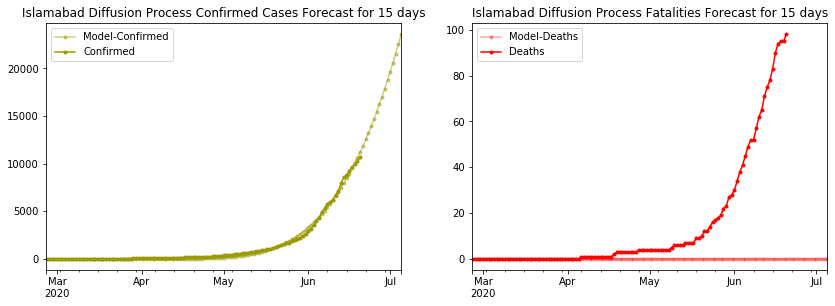

In [151]:
province = 'Islamabad'
df = get_time_series_province_pr('ICT')
stats = []
print('{} of Pakistan COVID-19 Prediction'.format('ICT'))
opt_display_model_pr(df, stats, province)

In [152]:
df = get_time_series_province_pr('ICT')
print('{} COVID-19 Prediction'.format('Islamabad')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Islamabad COVID-19 Prediction


Confirmed               Deaths      Model-Confirmed  \
2020-05-06                  521                    4                  277   
2020-05-08                  609                    4                  352   
2020-05-10                  679                    6                  442   
2020-05-12                  759                    6                  550   
2020-05-14                  866                    7                  679   
2020-05-16                  947                    7                  832   
2020-05-18                1,034                    9                1,011   
2020-05-20                1,235                   10                1,221   
2020-05-22                1,457                   12                1,464   
2020-05-24                1,641                   16                1,744   
2020-05-26                1,879                   18                2,065   
2020-05-28                2,100                   22                2,432   
2020-05-30                2,418                   27                2,847   
2020-06-02                3,188                   34                3,570   
2020-06-04                3,946                   41                4,126   
2020-06-06                4,979                   49                4,747   
2020-06-08                5,785                   52                5,435   
2020-06-10                6,236                   62                6,197   
2020-06-12                7,163                   71                7,036   
2020-06-14                8,569                   78                7,957   
2020-06-16                9,242                   90                8,964   
2020-06-18                9,941                   95               10,061   
2020-06-20               10,662                   98               11,253   
2020-06-22                  nan                  nan               12,544   
2020-06-24                  nan                  nan               13,937   
2020-06-26                  nan                  nan               15,436   
2020-06-28                  nan                  nan               17,044   
2020-06-30                  nan                  nan               18,766   
2020-07-02                  nan                  nan               20,604   
2020-07-04                  nan                  nan               22,560   

            Model-Deaths  
2020-05-06             0  
2020-05-08             0  
2020-05-10             0  
2020-05-12             0  
2020-05-14             0  
2020-05-16             0  
2020-05-18             0  
2020-05-20             0  
2020-05-22             0  
2020-05-24             0  
2020-05-26             0  
2020-05-28             0  
2020-05-30             0  
2020-06-02             0  
2020-06-04             0  
2020-06-06             0  
2020-06-08             0  
2020-06-10             0  
2020-06-12             0  
2020-06-14             0  
2020-06-16             0  
2020-06-18             0  
2020-06-20             0  
2020-06-22             0  
2020-06-24             0  
2020-06-26             0  
2020-06-28             0  
2020-06-30             0  
2020-07-02             0  
2020-07-04             0

### Sindh

Sindh of Pakistan COVID-19 Prediction


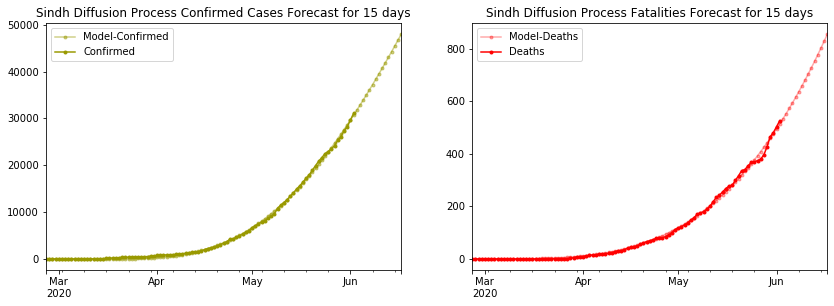

In [99]:
province = 'Sindh'
df = get_time_series_province_pr('Sindh')
stats = []
print('{} of Pakistan COVID-19 Prediction'.format('Sindh'))
opt_display_model_pr(df, stats, province)

In [100]:
df = get_time_series_province_pr('Sindh')
print('{} COVID-19 Prediction'.format('Sindh')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Sindh COVID-19 Prediction


Confirmed               Deaths      Model-Confirmed  \
2020-04-18                2,355                   48                2,416   
2020-04-20                2,764                   61                2,888   
2020-04-22                3,373                   69                3,421   
2020-04-24                4,232                   78                4,019   
2020-04-26                4,615                   81                4,683   
2020-04-28                5,291                   92                5,417   
2020-04-30                6,053                  112                6,224   
2020-05-02                7,102                  122                7,105   
2020-05-04                7,882                  137                8,062   
2020-05-06                8,640                  157                9,097   
2020-05-08                9,691                  175               10,211   
2020-05-10               11,480                  189               11,404   
2020-05-12               12,610                  218               12,677   
2020-05-14               14,099                  243               14,029   
2020-05-16               15,590                  268               15,461   
2020-05-18               17,241                  280               16,973   
2020-05-20               18,964                  316               18,562   
2020-05-22               20,883                  340               20,228   
2020-05-24               22,491                  367               21,969   
2020-05-26               23,507                  374               23,785   
2020-05-28               25,309                  396               25,672   
2020-05-30               27,360                  465               27,628   
2020-06-02               31,086                  526               30,689   
2020-06-04                  nan                  nan               32,810   
2020-06-06                  nan                  nan               34,991   
2020-06-08                  nan                  nan               37,230   
2020-06-10                  nan                  nan               39,524   
2020-06-12                  nan                  nan               41,870   
2020-06-14                  nan                  nan               44,265   
2020-06-16                  nan                  nan               46,706   

                   Model-Deaths  
2020-04-18                   51  
2020-04-20                   59  
2020-04-22                   68  
2020-04-24                   77  
2020-04-26                   88  
2020-04-28                   99  
2020-04-30                  112  
2020-05-02                  126  
2020-05-04                  140  
2020-05-06                  156  
2020-05-08                  174  
2020-05-10                  192  
2020-05-12                  212  
2020-05-14                  233  
2020-05-16                  256  
2020-05-18                  280  
2020-05-20                  306  
2020-05-22                  333  
2020-05-24                  362  
2020-05-26                  392  
2020-05-28                  425  
2020-05-30                  459  
2020-06-02                  514  
2020-06-04                  552  
2020-06-06                  593  
2020-06-08                  636  
2020-06-10                  681  
2020-06-12                  728  
2020-06-14                  777  
2020-06-16                  828

### Balochistan

Balochistan of Pakistan COVID-19 Prediction


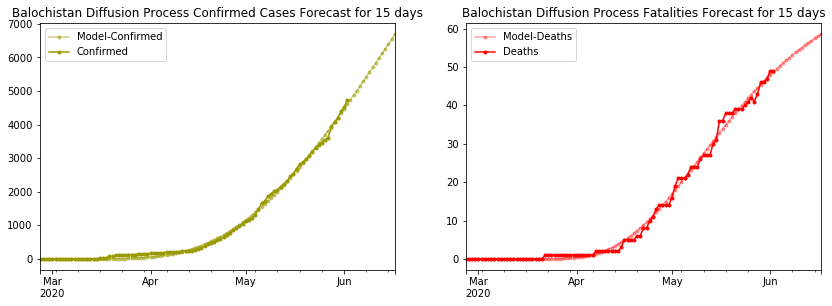

In [101]:
province = 'Balochistan'
df = get_time_series_province_pr('Balochistan')
stats = []
print('{} of Pakistan COVID-19 Prediction'.format('Balochistan'))
opt_display_model_pr(df, stats, province)

In [102]:
df = get_time_series_province_pr('Balochistan')
print('{} COVID-19 Prediction'.format('Balochistan')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Balochistan COVID-19 Prediction


Confirmed               Deaths      Model-Confirmed  \
2020-04-18                  376                    5                  439   
2020-04-20                  465                    6                  522   
2020-04-22                  552                    8                  615   
2020-04-24                  656                   10                  718   
2020-04-26                  781                   13                  831   
2020-04-28                  915                   14                  955   
2020-04-30                1,049                   14                1,089   
2020-05-02                1,172                   19                1,233   
2020-05-04                1,321                   21                1,388   
2020-05-06                1,659                   22                1,553   
2020-05-08                1,876                   24                1,728   
2020-05-10                2,017                   26                1,912   
2020-05-12                2,158                   27                2,107   
2020-05-14                2,310                   30                2,310   
2020-05-16                2,544                   36                2,522   
2020-05-18                2,820                   38                2,742   
2020-05-20                2,968                   38                2,970   
2020-05-22                3,198                   39                3,205   
2020-05-24                3,407                   40                3,447   
2020-05-26                3,536                   42                3,696   
2020-05-28                3,928                   43                3,950   
2020-05-30                4,193                   46                4,209   
2020-06-02                4,740                   49                4,607   
2020-06-04                  nan                  nan                4,877   
2020-06-06                  nan                  nan                5,150   
2020-06-08                  nan                  nan                5,426   
2020-06-10                  nan                  nan                5,705   
2020-06-12                  nan                  nan                5,985   
2020-06-14                  nan                  nan                6,266   
2020-06-16                  nan                  nan                6,548   

                   Model-Deaths  
2020-04-18                    6  
2020-04-20                    7  
2020-04-22                    9  
2020-04-24                   10  
2020-04-26                   12  
2020-04-28                   14  
2020-04-30                   16  
2020-05-02                   18  
2020-05-04                   20  
2020-05-06                   22  
2020-05-08                   24  
2020-05-10                   26  
2020-05-12                   29  
2020-05-14                   31  
2020-05-16                   33  
2020-05-18                   35  
2020-05-20                   37  
2020-05-22                   39  
2020-05-24                   41  
2020-05-26                   43  
2020-05-28                   45  
2020-05-30                   46  
2020-06-02                   49  
2020-06-04                   50  
2020-06-06                   52  
2020-06-08                   53  
2020-06-10                   54  
2020-06-12                   56  
2020-06-14                   57  
2020-06-16                   58

### KP

KPK of Pakistan COVID-19 Prediction


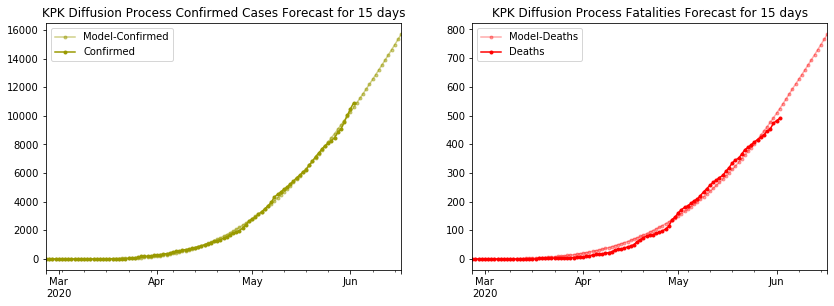

In [103]:
province = 'KPK'
df = get_time_series_province_pr('KP')
stats = []
print('{} of Pakistan COVID-19 Prediction'.format('KPK'))
opt_display_model_pr(df, stats, province)

In [104]:
df = get_time_series_province_pr('KP')
print('{} COVID-19 Prediction'.format('KPK')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

KPK COVID-19 Prediction


Confirmed               Deaths      Model-Confirmed  \
2020-04-18                1,137                   60                1,177   
2020-04-20                1,276                   74                1,371   
2020-04-22                1,453                   83                1,585   
2020-04-24                1,708                   89                1,819   
2020-04-26                1,864                   98                2,074   
2020-04-28                2,160                  114                2,351   
2020-04-30                2,627                  146                2,649   
2020-05-02                2,907                  172                2,968   
2020-05-04                3,288                  185                3,310   
2020-05-06                3,712                  203                3,673   
2020-05-08                4,327                  221                4,059   
2020-05-10                4,669                  245                4,466   
2020-05-12                5,021                  267                4,894   
2020-05-14                5,423                  284                5,344   
2020-05-16                5,847                  305                5,815   
2020-05-18                6,230                  334                6,306   
2020-05-20                6,815                  351                6,817   
2020-05-22                7,391                  381                7,347   
2020-05-24                7,905                  398                7,896   
2020-05-26                8,259                  416                8,463   
2020-05-28                8,842                  432                9,048   
2020-05-30                9,540                  453                9,650   
2020-06-02               10,897                  490               10,582   
2020-06-04                  nan                  nan               11,222   
2020-06-06                  nan                  nan               11,876   
2020-06-08                  nan                  nan               12,543   
2020-06-10                  nan                  nan               13,223   
2020-06-12                  nan                  nan               13,915   
2020-06-14                  nan                  nan               14,617   
2020-06-16                  nan                  nan               15,329   

                   Model-Deaths  
2020-04-18                   74  
2020-04-20                   83  
2020-04-22                   94  
2020-04-24                  105  
2020-04-26                  117  
2020-04-28                  129  
2020-04-30                  143  
2020-05-02                  158  
2020-05-04                  173  
2020-05-06                  190  
2020-05-08                  208  
2020-05-10                  226  
2020-05-12                  246  
2020-05-14                  267  
2020-05-16                  289  
2020-05-18                  312  
2020-05-20                  336  
2020-05-22                  362  
2020-05-24                  388  
2020-05-26                  416  
2020-05-28                  445  
2020-05-30                  476  
2020-06-02                  524  
2020-06-04                  558  
2020-06-06                  593  
2020-06-08                  626  
2020-06-10                  660  
2020-06-12                  695  
2020-06-14                  730  
2020-06-16                  765

### AJK

AJK of Pakistan COVID-19 Prediction


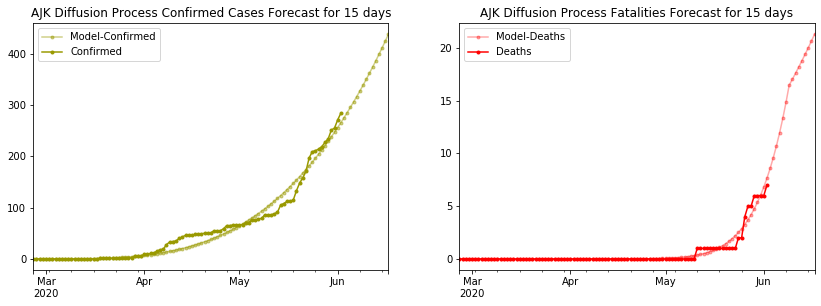

In [105]:
province = 'AJK'
df = get_time_series_province_pr('AJK')
stats = []
print('{} of Pakistan COVID-19 Prediction'.format('AJK'))
opt_display_model_pr(df, stats, province)

In [106]:
df = get_time_series_province_pr('AJK')
print('{} COVID-19 Prediction'.format('AJK')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 3 == 0].tail(30)

AJK COVID-19 Prediction


Confirmed               Deaths      Model-Confirmed  \
2020-03-18                    1                    0                    1   
2020-03-21                    1                    0                    2   
2020-03-24                    1                    0                    3   
2020-03-27                    2                    0                    4   
2020-03-30                    6                    0                    6   
2020-04-03                   11                    0                    9   
2020-04-06                   18                    0                   11   
2020-04-09                   33                    0                   15   
2020-04-12                   40                    0                   19   
2020-04-15                   46                    0                   24   
2020-04-18                   48                    0                   29   
2020-04-21                   51                    0                   36   
2020-04-24                   55                    0                   43   
2020-04-27                   65                    0                   52   
2020-04-30                   66                    0                   61   
2020-05-03                   71                    0                   72   
2020-05-06                   76                    0                   84   
2020-05-09                   86                    0                   98   
2020-05-12                   88                    1                  113   
2020-05-15                  108                    1                  129   
2020-05-18                  115                    1                  147   
2020-05-21                  158                    1                  167   
2020-05-24                  209                    2                  189   
2020-05-27                  219                    5                  212   
2020-05-30                  251                    6                  238   
2020-06-03                  nan                  nan                  275   
2020-06-06                  nan                  nan                  306   
2020-06-09                  nan                  nan                  338   
2020-06-12                  nan                  nan                  373   
2020-06-15                  nan                  nan                  411   

                   Model-Deaths  
2020-03-18                    0  
2020-03-21                    0  
2020-03-24                    0  
2020-03-27                    0  
2020-03-30                    0  
2020-04-03                    0  
2020-04-06                    0  
2020-04-09                    0  
2020-04-12                    0  
2020-04-15                    0  
2020-04-18                    0  
2020-04-21                    0  
2020-04-24                    0  
2020-04-27                    0  
2020-04-30                    0  
2020-05-03                    0  
2020-05-06                    0  
2020-05-09                    0  
2020-05-12                    0  
2020-05-15                    1  
2020-05-18                    1  
2020-05-21                    2  
2020-05-24                    3  
2020-05-27                    4  
2020-05-30                    5  
2020-06-03                    9  
2020-06-06                   12  
2020-06-09                   16  
2020-06-12                   18  
2020-06-15                   20

### GB

In [153]:
province = 'GB'
df = get_time_series_province_pr('GB')
stats = []
print('{} of Pakistan COVID-19 Prediction'.format('GB'))
opt_display_model_pr(df, stats, province)

GB of Pakistan COVID-19 Prediction


In [154]:
df = get_time_series_province_pr('GB')
print('{} COVID-19 Prediction'.format('GB')) 
province = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, province], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

GB COVID-19 Prediction


Confirmed               Deaths  Model-Confirmed  \
2020-05-06                  388                    3                0   
2020-05-08                  421                    3                0   
2020-05-10                  442                    4                0   
2020-05-12                  475                    4                0   
2020-05-14                  501                    4                0   
2020-05-16                  527                    4                0   
2020-05-18                  550                    4                0   
2020-05-20                  579                    4                0   
2020-05-22                  607                    4                0   
2020-05-24                  619                    7                0   
2020-05-26                  638                    9                0   
2020-05-28                  658                    9                0   
2020-05-30                  678                   11                0   
2020-06-02                  779                   12                0   
2020-06-04                  852                   12                0   
2020-06-06                  927                   13                0   
2020-06-08                  952                   14                0   
2020-06-10                1,018                   14                0   
2020-06-12                1,044                   16                0   
2020-06-14                1,129                   16                0   
2020-06-16                1,164                   17                0   
2020-06-18                1,225                   18                0   
2020-06-20                1,278                   21                0   
2020-06-22                  nan                  nan                0   
2020-06-24                  nan                  nan                0   
2020-06-26                  nan                  nan                0   
2020-06-28                  nan                  nan                0   
2020-06-30                  nan                  nan                0   
2020-07-02                  nan                  nan                0   
2020-07-04                  nan                  nan                0   

            Model-Deaths  
2020-05-06             0  
2020-05-08             0  
2020-05-10             0  
2020-05-12             0  
2020-05-14             0  
2020-05-16             0  
2020-05-18             0  
2020-05-20             0  
2020-05-22             0  
2020-05-24             0  
2020-05-26             0  
2020-05-28             0  
2020-05-30             0  
2020-06-02             0  
2020-06-04             0  
2020-06-06             0  
2020-06-08             0  
2020-06-10             0  
2020-06-12             0  
2020-06-14             0  
2020-06-16             0  
2020-06-18             0  
2020-06-20             0  
2020-06-22             0  
2020-06-24             0  
2020-06-26             0  
2020-06-28             0  
2020-06-30             0  
2020-07-02             0  
2020-07-04             0

### Pakistan National Projection

Pakistan COVID-19 Prediction


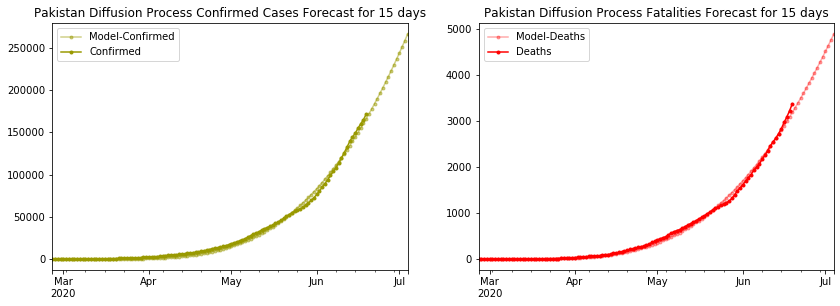

In [243]:
stats = []
country = 'Pakistan'
df = fulltable_pr[['Region', 'Date', 'Confirmed', 'Deaths']].groupby('Date').sum()
print('Pakistan COVID-19 Prediction')
opt_display_model_pr(df, stats, country)

__Predictions Table__

In [244]:
model = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, model], axis=1)
concat_df[concat_df.index.day % 2 == 1].tail(25)

Confirmed               Deaths      Model-Confirmed  \
2020-05-17               42,125                  903               40,315   
2020-05-19               45,898                  985               44,828   
2020-05-21               50,694                1,067               49,687   
2020-05-23               54,601                1,133               54,903   
2020-05-25               57,705                1,197               60,491   
2020-05-27               61,227                1,260               66,461   
2020-05-29               66,457                1,395               72,826   
2020-05-31               72,460                1,543               79,598   
2020-06-01               76,398                1,621               83,140   
2020-06-03               85,264                1,770               90,543   
2020-06-05               93,983                1,935               98,380   
2020-06-07              103,671                2,067              106,660   
2020-06-09              113,702                2,255              115,395   
2020-06-11              125,933                2,463              124,592   
2020-06-13              139,230                2,632              134,261   
2020-06-15              148,921                2,839              144,410   
2020-06-17              160,118                3,093              155,047   
2020-06-19              171,666                3,382              166,178   
2020-06-21                  nan                  nan              177,812   
2020-06-23                  nan                  nan              189,953   
2020-06-25                  nan                  nan              202,607   
2020-06-27                  nan                  nan              215,780   
2020-06-29                  nan                  nan              229,476   
2020-07-01                  nan                  nan              243,699   
2020-07-03                  nan                  nan              258,453   

                   Model-Deaths  
2020-05-17                  878  
2020-05-19                  967  
2020-05-21                1,063  
2020-05-23                1,164  
2020-05-25                1,272  
2020-05-27                1,386  
2020-05-29                1,507  
2020-05-31                1,634  
2020-06-01                1,700  
2020-06-03                1,838  
2020-06-05                1,982  
2020-06-07                2,133  
2020-06-09                2,292  
2020-06-11                2,457  
2020-06-13                2,630  
2020-06-15                2,810  
2020-06-17                2,998  
2020-06-19                3,193  
2020-06-21                3,395  
2020-06-23                3,605  
2020-06-25                3,822  
2020-06-27                4,046  
2020-06-29                4,278  
2020-07-01                4,518  
2020-07-03                4,765

### SARIMA 

Text(0, 0.5, 'Fatalities')

<Figure size 432x288 with 0 Axes>

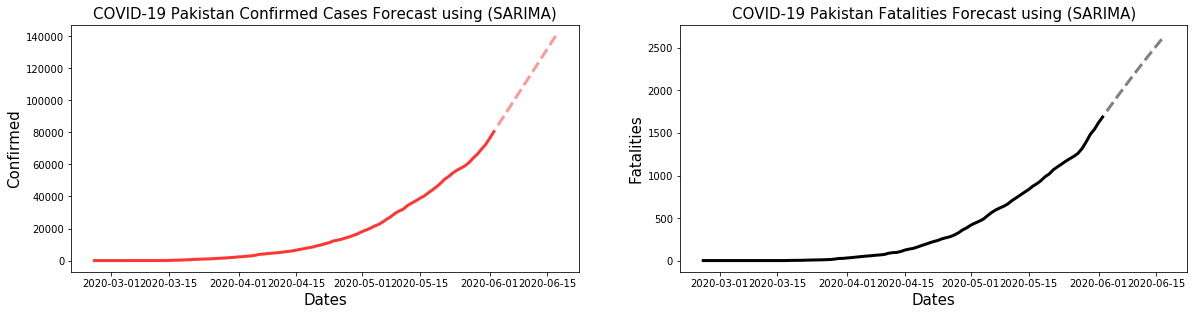

In [109]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#plt.style.use('fivethirtyeight')
%matplotlib inline
global fulltable
# SARIMA Confirmed
predgrp = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
pred_cnfrm = predgrp.loc[:,["Date","Confirmed"]]
pr_data_cf = pred_cnfrm
pr_data_cf.columns = ['ds','y']

arima = SARIMAX(pr_data_cf['y'], order=(3, 1, 0))
model = arima.fit()
forecast_c = model.forecast(steps= 15)
df_c  = forecast_c.reset_index().drop('index',axis=1)
pred_c = list(forecast_c)
pred_c

# SARIMA Fatalities
pred_exp = predgrp.loc[:,["Date","Deaths"]]
pr_data_e = pred_exp
pr_data_e.columns = ['ds','y']

arima_e = SARIMAX(pr_data_e['y'], order=(3, 1, 0))
arima_e = arima_e.fit(trend='c', full_output=True, disp=True)
forecast_e = arima_e.forecast(steps= 15)
pred_e = list(forecast_e)

# Plot Forecast
start_date = pr_data_cf['ds'].max() 
prediction_dates = []
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
# '#FF3633' | '#8dc354' | '#000000' | '#ff9999'
plt.figure(1)
plt.figure(figsize= (20,10))    
ax1 = plt.subplot(221)
ax1.plot(pr_data_cf['ds'], pr_data_cf['y'], linewidth = 3, linestyle='-', color = '#FF3633')
ax1.plot(prediction_dates, pred_c, linewidth = 3, linestyle='--', color = '#ff9999')

ax2 = plt.subplot(222)
ax2.plot(pr_data_e['ds'], pr_data_e['y'], linewidth = 3, linestyle='-', color = '#000000')
ax2.plot(prediction_dates, pred_e, linewidth = 3, linestyle='--', color = 'grey')


ax1.set_title('COVID-19 Pakistan Confirmed Cases Forecast using (SARIMA)', size=15)
ax1.set_xlabel('Dates', size=15)
ax1.set_ylabel('Confirmed', size=15)

ax2.set_title('COVID-19 Pakistan Fatalities Forecast using (SARIMA)',  size=15)
ax2.set_xlabel('Dates', size=15)
ax2.set_ylabel('Fatalities', size=15)

In [110]:
# concat_df
dates = pd.to_datetime(prediction_dates)
dates = pd.DataFrame(dates)
dates.columns = ['Dates']
dates
ar_c = pd.DataFrame(pred_c)
ar_c.columns = ['SARIMAX_Confirmed']
ar_c
ar_e = pd.DataFrame(pred_e, dtype=int)
ar_e.columns = ['SARIMAX_Deaths']
ar_e

#extended_model_ar = pd.DataFrame(dates, pred_c, dtype=int)
#extended_model_ar.set_index(0, inplace=True)
#extended_model_ar.columns = ['ARIMA-Confirmed']
#extended_model_ar

#pr_data_c['y']
concat_sar = pd.concat([dates, ar_c, ar_e ], axis=1)
concat_sar

Dates    SARIMAX_Confirmed  SARIMAX_Deaths
0  2020-06-03               84,413            1756
1  2020-06-04               88,399            1823
2  2020-06-05               92,379            1890
3  2020-06-06               96,359            1956
4  2020-06-07              100,339            2021
5  2020-06-08              104,319            2086
6  2020-06-09              108,299            2150
7  2020-06-10              112,279            2213
8  2020-06-11              116,259            2276
9  2020-06-12              120,239            2338
10 2020-06-13              124,219            2400
11 2020-06-14              128,199            2461
12 2020-06-15              132,179            2521
13 2020-06-16              136,159            2581
14 2020-06-17              140,139            2641

In [93]:
# from sklearn import metrics
# np.sqrt(metrics.mean_squared_error(pr_data_cf['y'], pred_c))

__SARIMA Diagnostics__ 

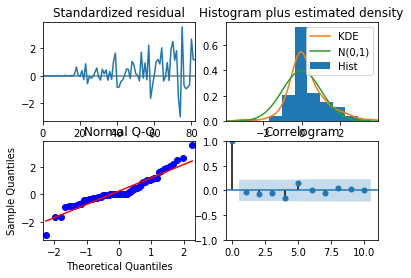

In [94]:
model.plot_diagnostics()
plt.show()

In [95]:
from statsmodels.tsa.arima_model import ARIMA

print("ARIMA_1")
arima1 = ARIMA(pr_data['y'], order=(1, 1, 0))
arima1 = arima1.fit(trend='c', full_output=True, disp=True)
print("AIC: ",arima1.aic,",","BIC: ", arima1.bic)
residuals = arima1.resid
mae = np.mean(np.abs(residuals))
print("RMSE: ",mae)
print("ARIMA_2")
arima2 = ARIMA(pr_data['y'], order=(2, 1, 0))
arima2 = arima2.fit(trend='c', full_output=True, disp=True)
print("AIC: ",arima2.aic,",", "BIC: ",arima2.bic)
residuals = arima2.resid
mae = np.mean(np.abs(residuals))
print("RMSE:",mae)
print("ARIMA_3")
arima_3 = ARIMA(pr_data['y'], order=(3, 1, 0))
arima_3 = arima_3.fit(trend='c', full_output=True, disp=True)
print("AIC: ",arima_3.aic,",","BIC: ", arima_3.bic)
residuals = arima_3.resid
mae = np.mean(np.abs(residuals))
print("RMSE: ",mae)
print("ARIMA_4")
arima_4 = ARIMA(pr_data['y'], order=(4, 1, 0))
arima_4 = arima_4.fit(trend='c', full_output=True, disp=True)
print("AIC: ",arima_4.aic,",","BIC: ", arima_4.bic)
residuals = arima_4.resid
mae = np.mean(np.abs(residuals))
print("RMSE: ",mae)
print("ARIMA_5")
arima5 = ARIMA(pr_data['y'], order=(5, 1, 0))
arima5 = arima5.fit(trend='c', full_output=True, disp=True)
print("AIC: ",arima5.aic,",","BIC: ", arima5.bic)
residuals = arima5.resid
mae = np.mean(np.abs(residuals))
print("RMSE: ",mae)
print("ARIMA_6")
arima_6 = ARIMA(pr_data['y'], order=(6, 1, 0))
arima_6 = arima_6.fit(trend='c', full_output=True, disp=True)
print("AIC: ",arima_6.aic,",","BIC: ", arima_6.bic)
residuals = arima_6.resid
mae = np.mean(np.abs(residuals))
print("RMSE: ",mae)



# forecast = arima.forecast(steps= 15)
# pred = list(forecast[0])

# start_date = pr_data['ds'].max()
# prediction_dates = []
# for i in range(15):
#     date = start_date + datetime.timedelta(days=1)
#     prediction_dates.append(date)
#     start_date = date
# plt.figure(figsize= (10,7))
# plt.xlabel("Dates",fontsize = 15)
# plt.ylabel('Cofirmed Cases',fontsize = 15)
# plt.title("Predicted Values for the next 15 Days" , fontsize = 20)

# #'#ff9999'-->pink
# plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = 'c',label = 'Confirmed Forecast');
# plt.plot_date(y=pr_data['y'],x=pr_data['ds'],linestyle = '-',color = 'blue',label = 'Confirmed');
# plt.legend();

ARIMA_1
AIC:  500.7432227599161 , BIC:  507.99974458330587
RMSE:  3.362726402950715
ARIMA_2
AIC:  500.6093654555907 , BIC:  510.2847278867771
RMSE: 3.2954051105666826
ARIMA_3
AIC:  495.9393109326186 , BIC:  508.03351397160156
RMSE:  3.1203563055880457
ARIMA_4
AIC:  507.12103341035277 , BIC:  521.6340770571323
RMSE:  2.9232144824110273
ARIMA_5
AIC:  492.59382895461147 , BIC:  509.52571320918764
RMSE:  2.9221502877669345
ARIMA_6
AIC:  493.73413742947355 , BIC:  513.0848622918463
RMSE:  2.896153850256178


### Holt Winter’s Exponential Smoothing (HWES)

In [78]:
import datetime
from statsmodels.tsa.holtwinters import ExponentialSmoothing

global fulltable

predgrp = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
pred_cnfrm = predgrp.loc[:,["Date","Confirmed"]]
pr_data = pred_cnfrm
pr_data.columns = ['ds','y']

# fit model
model = ExponentialSmoothing(pr_data['y'])
model_fit = model.fit()
# make prediction
yhat = model_fit.predict()

# Plot Forecast
start_date = pr_data['ds'].max() 
prediction_dates = []
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date

# # Plot Forecast
# start_date = pr_data['ds'].max() 
# prediction_dates = []
# for i in range(15):
#     date = start_date + datetime.timedelta(days=1)
#     prediction_dates.append(date)
#     start_date = date

# plt.plot_date(x=prediction_dates,y=pred_c)
# plt.show()

### Growth Factor

In [216]:
predgrp = fulltable.groupby("Date")[["Confirmed","Recovered","Deaths"]].sum().reset_index()
predgrp['Date']
predgrp = predgrp.replace(0, np.nan) 
pred_cnfrm = predgrp.loc[:,"Confirmed"].dropna()
pred_data = pred_cnfrm.values.tolist()

In [217]:
growth_diff = []

for i in range(1,len(pred_data)):
    growth_diff.append(pred_data[i] / pred_data[i-1])

growth_factor = sum(growth_diff)/len(growth_diff)
print('Average growth factor',growth_factor)

Average growth factor 1.192013530291749


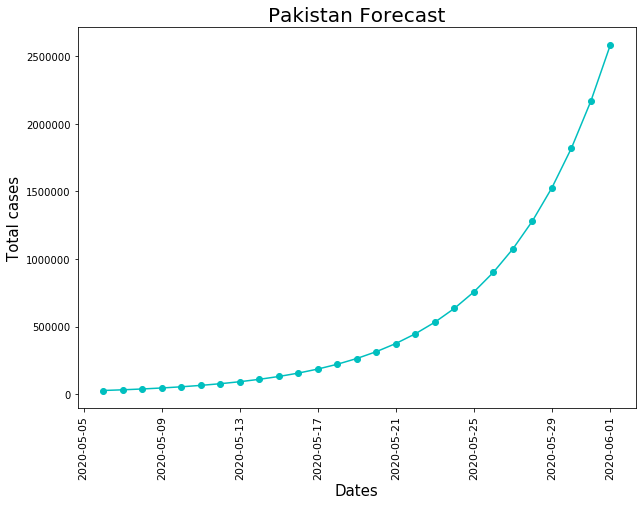

In [218]:
import datetime
prediction_dates = []
dates_pk = predgrp.loc[:,"Date"]
dates_pk
start_date = dates_pk[len(dates_pk)-1]
start_date
#start_date = dates_india[len(dates_india) - 1]
for i in range(27):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
previous_day_cases = pred_cnfrm[len(dates_pk) - 1]
previous_day_cases
predicted_cases = []

for i in range(27):
    predicted_value = previous_day_cases *  growth_factor
    predicted_cases.append(predicted_value)
    previous_day_cases = predicted_value

plt.figure(figsize= (10,7))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 15)
plt.ylabel('Total cases',fontsize = 15)
plt.title("Pakistan Forecast" , fontsize = 20)
ax1 = plt.plot_date(y= predicted_cases,x= prediction_dates,linestyle ='-',color = 'c')